In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2, venn3, venn3_circles

from venn import venn, generate_petal_labels, generate_colors, draw_venn
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf
# from statsmodels.stats.weightstats import ttest_ind
import scipy.stats as stats
from scipy.stats import ttest_ind, chi2_contingency, mannwhitneyu, bootstrap, fisher_exact
from scipy.interpolate import make_interp_spline
from statsmodels.formula.api import ols
from statsmodels.formula.api import mixedlm
import os
import sys

rootPath = '../../'
dataPath = rootPath + 'data_preparation/biomarkers_acute_sample_462/'
dataFile462 = dataPath + 'master_acute_sample_462_X6.xlsx'
dataFile373 = dataPath + 'master_acute_sample_462_X7_helsinki.xlsx'

GOSEFile = rootPath + 'data/_neurobot_outcome_GOSE_scores.csv'
QoLIBRIOSFile = rootPath + 'data/_neurobot_outcome_QoLIBRIOS.csv'
deathFile = rootPath + 'data/Subject Death Information.xlsx'
neuroworseningFile = rootPath + 'data/_neurobot_neuroworsening_secondinsults.csv'
GOAT_RAVLT_File = rootPath + 'data/_neurobot_outcome_GOAT_RAVLT_scores.csv'
RPQFile = rootPath + 'data/_neurobot_OutcomesRPQ.csv'

resultFolder462 = 'results_462_4-25/'
resultFolder373 = 'results_462_5-5_helsinki/'
resultFolder373d1 = 'result_d1_CTpos/'

rank462 = 'acute_sample462_X6_rank_1.xlsx'
rank373 = 'acute_sample462_X7_rank_1.xlsx'
rank373d1 = 'acute_sample373_CTpos_rank_1.xlsx'

# statsFolder = root_path + 'results_462_4-25/stats/'
# statOutcome = statsFolder + 'acute_sample462_X6_cluster_outcome.xlsx'

# statsFolder = rootPath + 'results_462_5-5_helsinki/stats/'
# statOutcome = statsFolder + 'acute_sample462_X7_cluster_outcome.xlsx'

# bioFilePostfix = '_cluster1_462_X6_imputed_longintudinal.csv'
# bioFilePostfix = '_Cluster1_373_X7_longintudinal.csv'

biomarkers = ['GFAP', 'NFL', 'Tau', 'UCH-L1', 'S100B', 'NSE']

# tstatFile = statsFolder + 'T-test/tstat_cluster1_373.xlsx'

gOSEdict = {'GOSE3month': 3, 'GOSE6month': 6, 'GOSE12month': 12}
goodGOSE = {
    1:0, 2:0, 3:0, 4:0,
    5:0, 6:0, 7:1, 8:1
}
poorGOSE = {
    1:1, 2:1, 3:1, 4:1,
    5:0, 6:0, 7:0, 8:0
}

algs = {'km':'kmeans', 'ga':'gaussian_mixture', 'sp':'spectral', 'sk' : 'skm', 'ag' : 'agglomerative'}

ftsize = 24

controldataf = rootPath + 'data/Center-6-markers -Controls.xlsx'

In [2]:
#Control data
df1 = pd.read_excel(controldataf, sheet_name='Sheet1', usecols='A, B, C', header=0, index_col=0)
df1.columns = ['NSE', 'S100B']
df1 = df1.dropna()
df2 = pd.read_excel(controldataf, sheet_name='Sheet1', usecols='E, F, G, H, I', header=0, index_col=0)
df2.columns = ['GFAP', 'NFL', 'Tau', 'UCH-L1']
df2['GFAP'] = df2['GFAP'] / 1000 # Unit conversion form pg/ml -> ng/ml
ctldf = pd.merge(df1, df2, left_index=True, right_index=True, how='outer').reset_index(drop=True).dropna(how='all')
print(ctldf)

      NSE  S100B      GFAP       NFL       Tau     UCH-L1
1    1.92  0.069  0.047015  2.771224  0.268040  18.309728
2     NaN    NaN  0.048722  2.675160  0.010000   2.136064
3     NaN    NaN  0.017307  3.027688  0.010000  15.059824
4     NaN    NaN  0.069882  1.884848  0.583272  12.298608
5     NaN    NaN  0.014365  1.609768  4.052360   2.580536
..    ...    ...       ...       ...       ...        ...
124   NaN    NaN  0.025344  1.977368  0.165912  28.085592
125   NaN    NaN  0.006540  0.555384  0.987296   0.100000
126  1.04  0.031  0.030574  3.985600  0.316744  24.819832
127   NaN    NaN  0.011572  3.208872  0.046056  36.913240
128  1.74  0.038  0.022043  4.791288  0.025744  33.482336

[124 rows x 6 columns]


In [3]:
ro = []
for col in ['GFAP', 'NFL', 'Tau', 'UCH-L1']:
    l = df2[col]
    ro.append({
        'biomarker': col,
        'size': len(l),
        'Min' : f'{l.min():.2f}',
        'Max' : f'{l.max():.2f}',
        'Mean': f'{l.mean():.2f}',
        'Std dev' : f'{l.std():.2f}',
        'Median' : f'{l.median():.2f}',
        '1st Quartile': f'{l.quantile(0.25):.2f}',
        '3rd Quartile': f'{l.quantile(0.75):.2f}',
    })
for col in ['NSE', 'S100B']:
    l = df1[col]
    ro.append({
        'biomarker': col,
        'size': len(l),
        'Min' : f'{l.min():.2f}',
        'Max' : f'{l.max():.2f}',
        'Mean': f'{l.mean():.2f}',
        'Std dev' : f'{l.std():.2f}',
        'Median' : f'{l.median():.2f}',
        '1st Quartile': f'{l.quantile(0.25):.2f}',
        '3rd Quartile': f'{l.quantile(0.75):.2f}',
    })
rodf = pd.DataFrame(ro)
# rodf.to_csv('./ctrl_stat.csv', header= True, index=False)

CLASS result for cluster outcome data

In [4]:
class result:
    rootPath = '../../'
    def __init__(self, resultfolder, dataFile, rankFile):
        if not resultfolder.endswith('/'):
            folder += '/'
        self.resultPath = rootPath + resultfolder
        self.clusterPath = self.resultPath + 'cluster/'
        self.rankingPath = self.resultPath + 'ranking/'
        self.statsPath = self.resultPath + 'stats/'
        self.rankFile = self.rankingPath + rankFile
        self.dataFile = dataFile
        self.df = {}
        for bio in biomarkers:
            dfin = pd.read_excel(self.dataFile, sheet_name=bio, header=0, index_col=0)
            ctldf.index = dfin.index[:len(ctldf)]
            self.df[bio] = dfin.iloc[:, -5:]
            self.df[bio]['ctrl'] = ctldf[bio]
            self.dfindex = dfin.index
        return
    
    def getoutcome(self, biomarker, rank=1):
        outcome = pd.DataFrame()
        dfin = pd.read_excel(self.dataFile, sheet_name=biomarker, header=0, index_col=0)
        dfRank = pd.read_excel(self.rankFile, sheet_name=biomarker, header=0)
        fst_cluster = dfRank.iloc[rank - 1,0]
        fst_a, fst_c = fst_cluster.split('_')
        labelFile = self.clusterPath + biomarker + '/' + biomarker + '_' + algs[fst_a] + '_' + fst_c + '.csv'
        label = pd.read_csv(labelFile, header=0)
        label.index = self.dfindex
        df1 = dfin.iloc[:, -4]
        grouped = df1.groupby(label['Cluster']).mean()
        if grouped[1].mean() > grouped[2].mean():
            label['Cluster'] = label['Cluster'].replace({1:2, 2:1})
        outcome['Cluster'] = label
        clusterTitle = biomarker + ' ' + algs[fst_a] + ' ' + fst_c
        
        dfGOSE = pd.read_csv(GOSEFile, header=0 )
        dfGOSE = dfGOSE.iloc[:, [0, -3, -2, -1]].drop_duplicates()
        dfGOSE.set_index('subjectId', inplace=True)
        dfGOSE.replace('2_or_3', 3, inplace=True)
        dfGOSE = dfGOSE.apply(pd.to_numeric, errors='coerce')
        outcome['GOSE3month'] = dfGOSE['Subject.GOSE3monthEndpointDerived']
        outcome['GOSE6month'] = dfGOSE['Subject.GOSE6monthEndpointDerived']
        outcome['GOSE12month'] = dfGOSE['Subject.GOSE12monthEndpointDerived']
        
        df = pd.read_csv(QoLIBRIOSFile, header=0, index_col=0)
        df_qolib = df.pivot(columns='Outcomes.Timepoint', values='Outcomes.QoLIBRIOSTotalScore')        
        outcome['QoLIB3month'] = df_qolib['3mo']
        outcome['QoLIB6month'] = df_qolib['6mo']
        outcome['QoLIB12month']= df_qolib['12mo']
        # outcome['QoLIB24month']= df_qolib['24mo']
        # outcome['QoLIB2week']= df_qolib['2wk']

        df = pd.read_excel(deathFile, sheet_name='Subject Death Information', header=0, index_col=0)
        df['DateInj'] = pd.to_datetime(df['DateInj'])
        df['DeathDate'] = pd.to_datetime(df['DeathDate'])
        df['Deathbydays'] = (df['DeathDate'] - df['DateInj']).dt.days
        outcome['Deathbydays'] = df['Deathbydays']
        outcome['DeathCause'] = df['DeathCause'].replace({4:3}) # no #3 cause, replace all 4 with 3
        
        dfin = pd.read_excel(self.dataFile, sheet_name=biomarkers[0], header=0, index_col=0)
        outcome['GCS'] = dfin['GCS']
        
        dfwsn = pd.read_csv(neuroworseningFile, header=0)
        for k, v in {'InjuryHx.EDSecondInsultsNeuroWorse':'NeuroWorse'}.items():
        # for k, v in {'InjuryHx.EDComplEventHypoxia':'NeuroWorse'}.items():
            dfw = dfwsn[['subjectId', k]].drop_duplicates().set_index('subjectId')
            dfw[k] = dfw[k].replace({88: np.NaN})
            outcome[v] = dfw[k]
         
        return clusterTitle, outcome


PLOT CLUSTER BIOMARKER MEAN/ MEDIAN AND VIOLIN, BOX PLOT FOR DATA DISTRIBUTION

In [5]:
# Mean/ Median- quartile ploting violin plotting
units = {
    'GFAP' : 'ng/ ml', 'NFL' : 'pg/ ml', 'Tau' : 'pg/ ml', 'UCH-L1' : 'pg/ ml', 'S100B' : 'ng/ ml', 'NSE' : 'ng/ ml'
}
c_blue = '#7070FF'
c_red =  '#FF7070'
c_red1 = '#FFA0A0'
c_yellow = '#FFFF70'
c_green = '#70FF70'
c_green1 = '#A0FFA0'
colors = [c_blue, c_red, c_yellow, 'green', 'purple', 'orange', 'olive', 'cyan', 'brown', 'yellow']
x_labels = ['d1', 'd2', 'd3', 'd4', 'd5', 'ctrl']
def plotMean(df, label, biomarker, title, figFile='', isMedian=True, color=0, linewidth=0.5, linestyle='-', x_shift=0.2):
    label = label[(label ==1) | (label == 2)]
    # df1 =df[(label ==1) | (label == 2)]
    df_eval = df.iloc[:, :5].groupby(label)
    for name, group in df_eval:
        x1 = np.array(range(0,group.shape[1] + 0))
        if name == 1:
            x = x1 - x_shift
            legendlabel = f'low ({group.shape[0]})'
        else:
            x = x1 + x_shift
            legendlabel = f'high ({group.shape[0]})'
        if isMedian:
            y = group.median(axis=0)
            ymax = group.max(axis=0)
        else:
            y = group.mean(axis=0)          
        if pd.isna(y).any():
            print(group, name, ' has NaN and cannot plot')
            continue
        xnew = np.linspace(x.min(), x.max(), 300)
        if isMedian:
            y1 = group.quantile(0.25)
            y2 = group.quantile(0.75)
            sp1 = make_interp_spline(x, y1)
            sp2 = make_interp_spline(x, y2)
            ps1 = sp1(xnew)
            ps2 = sp2(xnew)
            plt.plot(xnew, ps1, color=colors[color], linewidth=0.75, linestyle='--')
            plt.plot(xnew, ps2, color=colors[color], linewidth=0.75, linestyle='--')
            plt.fill_between(xnew, ps1, ps2, color=colors[color], alpha = 0.3)
        spline = make_interp_spline(x, y)
        power_smooth = spline(xnew)
        plt.xticks(np.append(x1, 5), x_labels)
        # plt.xticks(np.append(x1, 5), x_labels, fontsize=ftsize)
        # plt.yticks(fontsize=ftsize-4)
        plt.scatter(x,y,marker='o',  c=colors[color])

        plt.plot(xnew, power_smooth, color=colors[color], label=legendlabel, linewidth=linewidth*2, linestyle=linestyle)   #f'C{name} ({group.shape[0]})'
        # plot * to mark p value significant
        # if name == 2:
        #     plt.scatter(x+0.1,ymax+0.1,marker='*',  c='black')
        color += 1
    # lgd = plt.legend(bbox_to_anchor = (1.25,1.0))
    # lgd = plt.legend(loc='lower left', ncol = 2)
    # lgd = plt.legend(loc='lower left', fontsize=ftsize-10, ncol = 2)
    lgd = plt.legend()
    # plt.ylabel(f'log( {units[biomarker]} )', fontsize=12)
    
    plt.xlabel('')
    plt.ylabel(f'log({units[biomarker]})')
    # plt.xlabel('',fontsize=ftsize)
    # plt.ylabel(f'log({units[biomarker]})', fontsize=ftsize)
    # if x_shift != 0:
    #     plt.ylabel(f'log( {units[biomarker]} )', fontsize=12)
    # else:
    #     plt.ylabel(units[biomarker], fontsize=12)   
    # if isMedian:
    #     title += ' - Median'
    # else:
    #     title += ' - Mean'
    plt.title(title)
    # plt.title(title, fontsize=ftsize)

    if figFile != '':
        plt.savefig(figFile,  bbox_inches='tight')  #bbox_extra_artists=(lgd,),
    # plt.show()
    # plt.close()
    return
def plotviolin(df, label, biomarker, title, figFile=''):
    df1 = pd.DataFrame()
    df1['Cluster'] = label
    df1[['d1', 'd2', 'd3', 'd4', 'd5']] = df.iloc[:, :5]
    dfc = df.iloc[:, 5:6]
    df1 =df1[(label ==1) | (label ==2)]
    df_long = pd.melt(df1, id_vars=['Cluster'], value_vars=['d1', 'd2', 'd3', 'd4', 'd5'], var_name='time', value_name=biomarker)
    # plt.figure(figsize=[9,6])
    sns.violinplot(data=df_long, x='time', y=biomarker, hue='Cluster', split=False, fill=True, dodge='auto', 
                   density_norm='width', common_norm=True,inner='point', cut=0, legend=False, 
                   linewidth=0.6, palette=[colors[0], colors[1]], alpha=0.5)
    sns.violinplot(data=dfc, x = [6]*len(dfc), y = 'ctrl', density_norm='width', common_norm=True,
                   inner='quartile', cut=0, legend=False,color = 'white')
    # plt.ylabel(units[biomarker])
    # plt.title(biomarker)
    # plt.ylim(0, (df_long[biomarker].max() + 2 * df_long[biomarker].median()) / 3)
    plotMean(df=df, label=label, figFile=figFile, biomarker=biomarker, title=title, isMedian=True)
    # plt.show()
    
def plotbox(df, biomarker, title, figFile=''):
    palette = ['cyan', 'cyan', 'cyan', 'cyan', 'cyan', 'white']
    df1 = pd.DataFrame()
    df1[['d1', 'd2', 'd3', 'd4', 'd5', 'ctrl']] = df
    sns.boxplot(data=df1, palette=palette, flierprops={"marker": "."}, showcaps=False)
    plt.ylabel(f'log({units[biomarker]})', fontsize=ftsize)
    plt.xlabel('time', fontsize=ftsize)
    plt.xticks([0,1,2,3,4,5],['d1','d2','d3','d4','d5', 'ctrl'], fontsize=ftsize)
    plt.yticks(fontsize=ftsize-6)
    plt.title(title, fontsize=ftsize)
    if figFile != '':
        plt.savefig(figFile + '_box.png', bbox_inches='tight')
    plt.show()
    df1['A'] = 1
    df_long = pd.melt(df1, id_vars=['A'], value_vars=['d1', 'd2', 'd3', 'd4', 'd5', 'ctrl'], var_name='time', value_name=biomarker)
    sns.violinplot(data=df_long, x='time', y=biomarker, fill=True, inner='quartile', cut=0, legend=False, 
                   linewidth=1, palette=palette, alpha=0.5)
    plt.ylabel(f'log({units[biomarker]})', fontsize=ftsize)
    plt.xlabel('time', fontsize=ftsize)
    plt.xticks([0,1,2,3,4,5],['d1','d2','d3','d4','d5', 'ctrl'], fontsize=ftsize)
    plt.yticks(fontsize=ftsize-6)
    plt.title(title, fontsize=ftsize)
    plt.show()
    # plotMean(df=df, label=df1['A'], biomarker=biomarker, figFile=figFile, title=biomarker, x_shift=0)
    # plt.ylabel(f'log( {units[biomarker]} )', fontsize=12)
    # plt.title(title)
    # if figFile != '':
    #     plt.savefig(figFile + 'violin.png', bbox_inches='tight')
    # plt.show()


VENN DIAGRAM FOR BIOMARKER CLUSTER AND GOSE OUTCOME

In [6]:
# Venn diagram
def venn3diagram(data, isneuroworse = False, isGOSE=False, figFile=''):
    c1 = {}
    c2 = {}
    df = pd.DataFrame()
    for bio in biomarkers:
        _, df = data.getoutcome(biomarker = bio)
        c1[bio] = set(df.index[df['Cluster'] == 1])
        c2[bio] = set(df.index[df['Cluster'] == 2])
        
    for g in gOSEdict:
        c1[g] = set(df.index[df[g] > 6])
        c2[g] = set(df.index[df[g] < 5])
        
    if isGOSE:
        #Venn diagram with biomarker and GOSE
        for g in gOSEdict:
            c1[g] = set(df.index[df[g] > 6])
            c2[g] = set(df.index[df[g] < 5])
        for b1 in biomarkers:
            for g2 in gOSEdict:
                venn3([c1[b1], c2[b1], c1[g2]], ('C1', 'C2', 'GOSE 7-8'))
                plt.title(b1 + ' - good ' + gOSEdict[g2])
                # plt.savefig(figFile + b1 + '_good_' + g2 + '.png')
                plt.show()
                venn3([c1[b1], c2[b1], c2[g2]], ('C1', 'C2', 'GOSE 1-4'))
                plt.title(b1 + ' - poor ' + gOSEdict[g2])
                if figFile != '':
                    plt.savefig(figFile + b1 + '_poor_' + g2 + '.png')
                plt.show()
    elif isneuroworse:
        v = 'NeuroWorse'
        c1[v] = set(df.index[df[v] == 0])
        c2[v] = set(df.index[df[v] == 1])
        for b1 in biomarkers:
            v1 = venn3([c1[b1], c2[b1], c2[v]], ('C1', 'C2', 'Neuroworsening'))
            # v1.get_label_by_id('101').set_text('0101')
            plt.title(b1 + ' - Neuro Worsening ')
            plt.show()
            venn3([c1[b1], c2[b1], c1[v]], ('C1', 'C2', 'No Neuroworsening'))
            plt.title(b1 + ' - No Neuro Worsening ')
            plt.show()
    else:
        #Venn diagram between biomarkers
        for i1, b1 in enumerate(biomarkers):
            for i2, b2 in enumerate(biomarkers):
                for i3, b3 in enumerate(biomarkers):
                    if (i1 < i2) and (i2 < i3):
                        # fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
                        v1 = venn3([c1[b1], c1[b2], c1[b3]], (f'{b1} C1({len(c1[b1])})', f'{b2} C1({len(c1[b2])})', f'{b3} C1({len(c1[b3])})'), set_colors=('blue', 'red', 'yellow'))      # (c_blue, c_red, c_yellow)
                        # plt.title('Lower trajectory cluster overlap')
                        # venn3([c1[b1], c1[b2], c1[b3]], (b1 + '-C1', b2 + '-C1', b3 + '-C1'), axes = axes[0])
                        for subset in v1.subset_labels:
                            if subset:
                                subset.set_text('')
                        v1.get_label_by_id('111').set_text(len(c1[b1] & c1[b2] & c1[b3]))
                        if figFile != '':
                            plt.savefig(figFile + 'C1_' + b1 + '_' + b2 + '_' + b3 + '.png', bbox_inches='tight')
                        plt.show()
                        
                        v2 = venn3([c2[b1], c2[b2], c2[b3]], (f'{b1} C2({len(c2[b1])})', f'{b2} C2({len(c2[b2])})', f'{b3} C2({len(c2[b3])})'), set_colors=('blue', 'red', 'yellow'))
                        for subset in v2.subset_labels:
                            if subset:
                                subset.set_text('')
                        v2.get_label_by_id('111').set_text(len(c2[b1] & c2[b2] & c2[b3]))

                        # plt.title('Higher trajectory cluster overlap')
                        if figFile != '':
                            plt.savefig(figFile + 'C2_' + b1 + '_' + b2 + '_' + b3 + '.png', bbox_inches='tight')
                        plt.show()
    return

def venn4diagram(data, figFile=''):
    c1 = {}
    c2 = {}
    df = pd.DataFrame()
    for bio in biomarkers:
        _, df = data.getoutcome(biomarker = bio)
        c1[bio] = set(df.index[df['Cluster'] == 1])
        c2[bio] = set(df.index[df['Cluster'] == 2])
    for i1, b1 in enumerate(biomarkers):
        for i2, b2 in enumerate(biomarkers):
            for i3, b3 in enumerate(biomarkers):
                for i4, b4 in enumerate(biomarkers):
                    if (i1 < i2) and (i2 < i3) and (i3 < i4):
                        data = {
                            f'{b1} C2({len(c2[b1])})' : c2[b1],
                            f'{b2} C2({len(c2[b2])})' : c2[b2],
                            f'{b3} C2({len(c2[b3])})' : c2[b3],
                            f'{b4} C2({len(c2[b4])})' : c2[b4]
                        }
                        petal_labels = generate_petal_labels(data.values(), fmt="{size}")
                        for k in petal_labels.keys():
                            if k != '1111':
                                petal_labels[k] = ''
                        draw_venn(
                            petal_labels=petal_labels, dataset_labels=data.keys(),
                            hint_hidden=False, colors=generate_colors(n_colors=4),
                            figsize=(8, 8), fontsize=14, legend_loc="best", ax=None
                        )

                        if figFile != '':
                            plt.savefig(figFile + 'High ' + b1 + '_' + b2 + '_' + b3 + '-' + b4 + '.png', bbox_inches='tight')
                        plt.show()
def venn5diagram(data, figFile=''):
    c1 = {}
    c2 = {}
    df = pd.DataFrame()
    for bio in biomarkers:
        _, df = data.getoutcome(biomarker = bio)
        c1[bio] = set(df.index[df['Cluster'] == 1])
        c2[bio] = set(df.index[df['Cluster'] == 2])
    for i1, b1 in enumerate(biomarkers):
        for i2, b2 in enumerate(biomarkers):
            for i3, b3 in enumerate(biomarkers):
                for i4, b4 in enumerate(biomarkers):
                    for i5, b5 in enumerate(biomarkers):
                        if (i1 < i2) and (i2 < i3) and (i3 < i4) and (i4 < i5):
                            data = {
                                f'{b1} C1({len(c1[b1])})' : c1[b1],
                                f'{b2} C1({len(c1[b2])})' : c1[b2],
                                f'{b3} C1({len(c1[b3])})' : c1[b3],
                                f'{b4} C1({len(c1[b4])})' : c1[b4],
                                f'{b5} C1({len(c1[b5])})' : c1[b5]
                            }
                            petal_labels = generate_petal_labels(data.values(), fmt="{size}")
                            for k in petal_labels.keys():
                                if k != '11111':
                                    petal_labels[k] = ''
                            draw_venn(
                                petal_labels=petal_labels, dataset_labels=data.keys(),
                                hint_hidden=False, colors=generate_colors(n_colors=5),
                                figsize=(8, 8), fontsize=14, legend_loc="best", ax=None
                            )

                            if figFile != '':
                                plt.savefig(figFile + 'Low ' + b1 + '_' + b2 + '_' + b3 + '-' + b4 + '_' + b5 + '.png', bbox_inches='tight')
                            plt.show()                       


STATISTIC T-TEST (PARAMETRIC) AND U-TEST (NON-PARAMETRIC)

In [7]:
# T-test for mean and U-test for median
def median_statistic(x, axis):
    return np.median(x, axis= axis)
# with pd.ExcelWriter(tstatFile, engine='xlsxwriter') as writer:
def ttest(res):
    result_df = pd.DataFrame()
    for bio in biomarkers:
        _, outcome = res.getoutcome(biomarker = bio)
        results = []
        for day in range(1, 6):
            day_data = bio + '_' + str(day)
            group1 = res.df[bio][outcome['Cluster'] == 1][day_data].dropna()
            group2 = res.df[bio][outcome['Cluster'] == 2][day_data].dropna()

            # Calculate mean and standard error for each group
            group1_mean = group1.mean()
            group1_se = group1.sem()
            group1_median = group1.median()
            group1_p1 = np.percentile(group1, 25)
            group1_p3 = np.percentile(group1, 75)

            boot1 = bootstrap(data=(group1.values,), statistic= median_statistic, confidence_level=0.95, method='percentile')
            boot1_low = boot1.confidence_interval.low
            boot1_high = boot1.confidence_interval.high
            # if bio == 'S100B' and day == 4:
            #     print('group1 ', group1.describe())
            #     print(np.unique(group1.values))
            #     print(np.isnan(group1.values).any())
            #     print(np.isinf(group1.values).any())
            group2_mean = group2.mean()
            group2_se = group2.sem()
            group2_median = group2.median()
            group2_p1 = np.percentile(group2, 25)
            group2_p3 = np.percentile(group2, 75)

            boot2 = bootstrap(statistic=median_statistic, data=(group2.values,), confidence_level=0.95, method='percentile')
            boot2_low = boot2.confidence_interval.low
            boot2_high = boot2.confidence_interval.high
            # if bio == 'S100B' and day == 1:
            #     print('group2 ', group2.describe())
            #     print(np.unique(group2.values))
            #     print(np.isnan(group2.values).any())
            #     print(np.isinf(group2.values).any())                
            # Perform t-test, u-test
            t_stat, p_value1 = ttest_ind(group1, group2)
            u_statistic, p_value2 = mannwhitneyu(group1, group2, alternative='two-sided')
            
            results.append({
                'biomarker': bio,             
                "Day": day,
                'C1 Median': round(group1_median, 2),
                'C1 95% CI': f'{round(boot1_low, 2)}, {round(boot1_high, 2)}',
                'C2 Median': round(group2_median, 2),
                'C2 95% CI': f'{round(boot2_low, 2)}, {round(boot2_high, 2)}',
                
                'C1 IQR': round(group1_p3 - group1_p1, 2),
                "C1 Mean": round(group1_mean, 2),
                "C1 SE": round(group1_se, 2),

                "C2 Mean": round(group2_mean, 2),
                "C2 SE": round(group2_se, 2),
                'C2 IQR': round(group2_p3 - group2_p1, 2),

                "T Statistic": round(t_stat, 2),
                "P value (T)": "{:.2e}".format(p_value1),
                "U Statistic": round(u_statistic, 2),
                "P value (U)": "{:.2e}".format(p_value2)
            })

        # Convert results to DataFrame for better display
        result_df = pd.concat([result_df, pd.DataFrame(results)], axis=0)
        # print(result_df[bio])
        # results_df.to_excel(writer, sheet_name=bio, header=True, index=False)
    result_df.reset_index(inplace=True, drop=True)
    return result_df
    


In [8]:
# U-test Mann-Whitney comparing median - embeded in ttest function!

def utest(res):
    result_df = pd.DataFrame()
    for bio in biomarkers:
        _, outcome = res.getoutcome(biomarker = bio)       
        results = []
        for day in range(1, 6):
            day_data = bio + '_' + str(day)
            group1 = res.df[bio][outcome['Cluster'] == 1][day_data].dropna()
            group2 = res.df[bio][outcome['Cluster'] == 2][day_data].dropna()

            # Calculate mean and standard error for each group
            group1_median = group1.median()
            group1_se = group1.sem()
            group2_median = group2.median()
            group2_se = group2.sem()

            # Perform U-test
            u_statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')

            results.append({
                'biomarker': bio,             
                "Day": day,
                "C1 Median": round(group1_median, 2),
                "C1 SE": round(group1_se, 2),
                "C2 Median": round(group2_median, 2),
                "C2 SE": round(group2_se, 2),
                "U Statistic": round(u_statistic, 2),
                "p value": "{:.2e}".format(p_value)
            })

        # Convert results to DataFrame for better display
        result_df = pd.concat([result_df, pd.DataFrame(results)], axis=0)
        # print(result_df[bio])
        # results_df.to_excel(writer, sheet_name=bio, header=True, index=False)
    result_df.reset_index(inplace=True, drop=True)
    return result_df
    


In [9]:
# Chi square test
def chi2t(s1, s2):
    crosstab = pd.crosstab(s1, s2)
    chi2, p_value, dim, expected = chi2_contingency(crosstab)
    return chi2, p_value
    
def chi2test(res):
    result_df=pd.DataFrame()
    for bio in biomarkers:
        _, outcome = res.getoutcome(biomarker = bio)
        results = []
        for i, g in enumerate(gOSEdict):
            goodoutcome = outcome[g].replace(goodGOSE)
            chi2, p_value = chi2t(outcome['Cluster'], goodoutcome)    
            results.append({
                'biomarker': bio,
                'outcome': 'good ' + gOSEdict[g],
                'Chi2': round(chi2, 2),
                'p value': "{:.2e}".format(p_value)
            })
            pooroutcome = outcome[g].replace(poorGOSE)
            chi2, p_value = chi2t(outcome['Cluster'], pooroutcome)    
            results.append({
                'biomarker': bio,
                'outcome': 'poor '  + gOSEdict[g],
                'Chi2': round(chi2, 2),
                'p value': "{:.2e}".format(p_value)
            })
        chi2, p_value = chi2t(outcome['Cluster'], outcome['NeuroWorse'])    
        results.append({
            'biomarker': bio,
            'outcome': 'Neuroworsening',
            'Chi2': round(chi2, 2),
            'p value': "{:.2e}".format(p_value)
        })            

            # print(f"{bio} Chi-square test at {gOSEdict[g]}: chi2 = {round(chi2[i], 3)}, p-value = {chi2_p[i]:.3e}")
        # result_df[bio]= pd.DataFrame(results)
        result_df = pd.concat([result_df, pd.DataFrame(results)], axis=0)
    result_df.reset_index(inplace=True, drop=True)
    return result_df
    

CHI SQUARE, ODDS RATIO CALCULATION FOR GOSE AT 3, 6 AND 12 MONTH WITH CLUSTER OUTCOME

In [10]:
# Odds ratio Chi2 test embedded
def oddsRatio(res):
    result_df = pd.DataFrame()
    for bio in biomarkers:
        _, outcome = res.getoutcome(biomarker = bio)
        results = []
        for tx, st in {'good': goodGOSE, 'poor': poorGOSE}.items():
            for g in gOSEdict:
                goutcome = outcome[g].replace(st)
                chi2, chi2_p_value = chi2t(outcome['Cluster'], goutcome)
                if tx == 'good':
                    coutcome = 2 - outcome['Cluster']
                else:
                    coutcome = outcome['Cluster'] - 1
                odds_crosst = pd.crosstab(coutcome, goutcome)
                oddsratio, odds_p_value = stats.fisher_exact(odds_crosst)
                ci_table = sm.stats.Table2x2(odds_crosst.values)
                ci_lower, ci_upper = ci_table.oddsratio_confint(alpha=0.05)  # 95% CI
                results.append({
                    'biomarker': bio,
                    'outcome': tx,
                    'month': gOSEdict[g],
                    'OR (95% CI)': f"{round(oddsratio, 2)} ({round(ci_lower, 2)}, {round(ci_upper, 2)}){'***' if odds_p_value < 0.001 else ('**' if odds_p_value < 0.01 else ('*' if odds_p_value < 0.05 else ''))}",
                    'OR': oddsratio,
                    'CI lower': ci_lower,
                    'CI upper': ci_upper,
                    'Odds p value': "{:.2e}".format(odds_p_value),
                    'Chi2 (p)': f"{round(chi2, 2)} {'***' if chi2_p_value < 0.001 else ('**' if chi2_p_value < 0.01 else ('*' if chi2_p_value < 0.05 else ''))}",
                    'Chi2': round(chi2, 2),
                    'Chi2 p value': "{:.2e}".format(chi2_p_value)
                })
        result_df = pd.concat([result_df, pd.DataFrame(results)], axis=0)
                # print(bio, gOSEdict[g], tx, round(oddsratio, 2), '{:.2e}'.format(p_value))
    return result_df    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    df = result_df.iloc[:-6, :]
    # Plot odds ratios with confidence intervals
    ax.errorbar(df["OR"], range(len(df)), 
                xerr=[df["OR"] - df["CI lower"], df["CI upper"] - df["OR"]],
                fmt='o', color='black', ecolor='blue', capsize=5, capthick=2)

    # Add vertical reference line at OR = 1 (neutral effect)
    ax.axvline(x=1, linestyle='--', color='gray', linewidth=1)

    # Labels and formatting
    ax.set_yticks(range(len(df)))
    ax.set_yticklabels(df["biomarker"] + df["outcome"])
    ax.set_xlabel("Odds Ratio (95% CI)")
    ax.set_title("Forest Plot of Odds Ratios")

    # Invert y-axis for better readability
    plt.gca().invert_yaxis()

    # Show plot
    plt.show()

    return result_df


In [11]:
def composite_linearMM(dfin, figpath=''):

    lmmResult = pd.DataFrame()
    for tx, st in {'good': goodGOSE, 'poor': poorGOSE}.items():
        # _, outcome = res.getoutcome(biomarker = bio)
        # map GOSE score to binary value
        outcome = dfin.copy()
        outcome = outcome[outcome['Composite'] != 1]
        outcome['Composite'] = outcome['Composite'].replace({0:1})
        for g in gOSEdict:
            outcome[g] = outcome[g].replace(st)
        # convert df to df_long longitudinal data 
        df_long = pd.melt(outcome, id_vars=['Composite'], value_vars=['GOSE3month', 'GOSE6month', 'GOSE12month'], var_name='time', value_name='GOSE')
        # Ensure Both Cluster and time are category variable before fitting to Linear Mixed Model
        df_long['Composite'] = df_long['Composite'].astype('category')
        df_long['time'] = df_long['time'].astype('category')
        # LMM model
        # model = mixedlm("GOSE ~ C(Cluster)  * C(time)", df_long, groups=df_long['time'], missing='drop')
        # model = mixedlm("GOSE ~ C(Cluster) + C(time) + C(Cluster):C(time)", df_long, groups=df_long['time'], missing='pandas')
        model = mixedlm("GOSE ~ Composite : time", df_long, groups=df_long['time'], missing='drop')
        result = model.fit()
        
        # plot_hist2(bio, stateGOSE=tx, df_long= df_long, outcome= outcome, figpath=figpath)   # 

        print(result.summary())
        summary_df = pd.DataFrame({
            'biomarker': 'Composite',
            'outcome': tx,
            'LMM Std Err': round(result.bse, 2),
            'LMM p value': result.pvalues.apply(lambda x: f'{x:.2e}')
        # 'Coef.': result.params,
        # 'z': result.tvalues,
        # '[0.025': result.conf_int()[0],
        # '0.975]': result.conf_int()[1]
        })
        print(f' Summary datat frame: \n{summary_df}') 
        print(f'index: {summary_df.index}')
        summary_df = summary_df.loc[['Composite[T.2]:time[GOSE6month]', 'Composite[T.2]:time[GOSE6month]', 'Composite[T.2]:time[GOSE12month]']]
        summary_df['month'] = [3, 6, 12]
        summary_df = summary_df[['biomarker', 'outcome', 'month', 'LMM Std Err', 'LMM p value']]
        lmmResult = pd.concat([lmmResult, summary_df], axis=0)
    lmmResult.reset_index(inplace=True, drop=True)
    print(lmmResult)
    return(lmmResult)
def composite_oddsRatio(dfin):
    result_df = pd.DataFrame()
    results = []
    for tx, st in {'good': goodGOSE, 'poor': poorGOSE}.items():
        outcome = dfin.copy()
        outcome = outcome[outcome['Composite'] != 1]
        outcome['Composite'] = outcome['Composite'].replace({0:1})
        for g in gOSEdict:
            goutcome = outcome[g].replace(st)
            chi2, chi2_p_value = chi2t(outcome['Composite'], goutcome)
            if tx == 'good':
                coutcome = 2 - outcome['Composite']
            else:
                coutcome = outcome['Composite'] - 1
            odds_crosst = pd.crosstab(coutcome, goutcome)
            oddsratio, odds_p_value = stats.fisher_exact(odds_crosst)
            ci_table = sm.stats.Table2x2(odds_crosst)
            ci_low, ci_high = ci_table.oddsratio_confint()
            results.append({
                'biomarker': 'Composite',
                'outcome': tx,
                'month': gOSEdict[g],
                'Odds ratio': round(oddsratio, 2),
                'Odds Ci': f'{ci_low:.2f}/ {ci_high:.2f}',
                'Odds p value': "{:.2e}".format(odds_p_value),
                'Chi2': round(chi2, 2),
                'Chi2 p value': "{:.2e}".format(chi2_p_value)
            })
    result_df = pd.DataFrame(results)
            # print(bio, gOSEdict[g], tx, round(oddsratio, 2), '{:.2e}'.format(p_value))
    return result_df


PLOT (GOOD/ POOR) GOSE DISTRIBUTION IN CLUSTER GROUP AT 3, 6 AND 12 MONTH

In [12]:
def add_label2(ax, bars, counts, labels):
    i = 0
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        if height > 0:  # Only add labels for non-zero bars
            label1 = labels[i]
            i += 1
            label2 = f'{count}'
            ax.annotate(label1,
                        xy=(bar.get_x() + bar.get_width() / 2, height - 15),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='center')
            # ax.annotate(label2,
            #             xy=(bar.get_x() + bar.get_width() / 2, height - 20),
            #             xytext=(0, 3),  # 3 points vertical offset
            #             textcoords="offset points",
            #             ha='center', va='bottom')
def plot_hist2(bio, stateGOSE, df_long, outcome, figpath=''):
    severity = stateGOSE

    # Histogram data split, only GOSE binary score = 1 will be used
    c1GOSE = df_long.loc[(df_long['Cluster'] == 1) & (df_long['GOSE'] == 1), 'time']
    c2GOSE = df_long.loc[(df_long['Cluster'] == 2) & (df_long['GOSE'] == 1), 'time']
    c1a = df_long.loc[(df_long['Cluster'] == 1), 'time']
    c2a = df_long.loc[(df_long['Cluster'] == 2), 'time']
    # Count the number of sample in each cluster
    c1count = outcome[outcome['Cluster'] == 1]['Cluster'].count()
    c2count = outcome[outcome['Cluster'] == 2]['Cluster'].count()
    # Plot histogram 
    fig, ax = plt.subplots()
    counts, edges, bars = plt.hist([c1a, c2a], bins=3, label=['C1: ' + str(c1count), 'C2: '+ str(c2count)], color=[c_blue, c_red], edgecolor='darkgrey', alpha=1)   # edgecolor='black'

    for b in bars:
        plt.bar_label(b)
    add_label2(ax, bars[0], counts[0], labels= ['C1', 'C1', 'C1'])
    add_label2(ax, bars[1], counts[1], labels= ['C2', 'C2', 'C2'])
    plt.ylim(0, max(max(counts[0]),max(counts[1])) * 1.1)
    counts, edges, bars = plt.hist([c1GOSE, c2GOSE], bins=3, label=[severity + ' GOSE',], edgecolor='blue', alpha=1, facecolor='none')
    for b in bars:
        plt.bar_label(b)
        # plt.bar_label(b, fmt=lambda x: f'{x/1:.2f}')
    add_labels(ax, bars[0], counts[0], c1count)
    add_labels(ax, bars[1], counts[1], c2count)
    # lgd = ax.legend(bbox_to_anchor = (1.30,1.0))
    plt.title(bio + ' ' + severity + ' outcome')
    ax.set_xticks([0.33, 1, 1.67], ['3 month', '6 month', '12 month'])
    if figpath != '':
        plt.savefig(figpath + bio + '_' + severity + '_GOSE.png', bbox_inches='tight')
    plt.show()


LINEAR MIXED MODEL FOR GOSE at 3, 6, and 12 MONTH VS CLUSTER OUTCOME

In [13]:
# LMM 
'''
Add label (%) to histogram
Text position adjustable with xy parameter in ax.annotate
'''
def add_labels(ax, bars, counts, total):
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        if height > 0:  # Only add labels for non-zero bars
            label = f'{count/total:.2%}'
            ax.annotate(label,
                        xy=(bar.get_x() + bar.get_width() / 2, height - 20),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='center')
def plot_hist(bio, isgoodGOSE, df_long, outcome):
    severity = 'good' if isgoodGOSE else 'poor'
    # Histogram data split, only GOSE binary score = 1 will be used
    c1GOSE = df_long.loc[(df_long['Cluster'] == 1) & (df_long['GOSE'] == 1), 'time']
    c2GOSE = df_long.loc[(df_long['Cluster'] == 2) & (df_long['GOSE'] == 1), 'time']
    # Count the number of sample in each cluster
    c1count = outcome[outcome['Cluster'] == 1]['Cluster'].count()
    c2count = outcome[outcome['Cluster'] == 2]['Cluster'].count()
    # Plot histogram 
    fig, ax = plt.subplots()
    counts, edges, bars = plt.hist([c1GOSE, c2GOSE], bins=3, label=['C1: ' + str(c1count), 'C2: '+ str(c2count)])
    for b in bars:
        plt.bar_label(b)
        # plt.bar_label(b, fmt=lambda x: f'{x/1:.2f}')
    add_labels(ax, bars[0], counts[0], c1count)
    add_labels(ax, bars[1], counts[1], c2count)
    lgd = ax.legend(bbox_to_anchor = (1.25,1.0))
    plt.title(bio + ' ' + severity + ' outcome')
    # plt.savefig(savePath + bio + '_' + severity + '_GOSE.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    
def linearMM(res, figpath=''):
    lmmResult = pd.DataFrame()
    for bio in biomarkers:
        # _, outcome = res.getoutcome(biomarker = bio)
        for tx, st in {'good': goodGOSE, 'poor': poorGOSE}.items():
            _, outcome = res.getoutcome(biomarker = bio)
            # map GOSE score to binary value
            for g in gOSEdict:
                outcome[g] = outcome[g].replace(st)
    
            # convert df to df_long longitudinal data 
            df_long = pd.melt(outcome, id_vars=['Cluster'], value_vars=['GOSE3month', 'GOSE6month', 'GOSE12month'], var_name='time', value_name='GOSE')
            # Ensure Both Cluster and time are category variable before fitting to Linear Mixed Model
            df_long['Cluster'] = df_long['Cluster'].astype('category')
            df_long['time'] = df_long['time'].astype('category')
            # LMM model
            # model = mixedlm("GOSE ~ C(Cluster)  * C(time)", df_long, groups=df_long['time'], missing='drop')
            # model = mixedlm("GOSE ~ C(Cluster) + C(time) + C(Cluster):C(time)", df_long, groups=df_long['time'], missing='pandas')
            model = mixedlm("GOSE ~ Cluster : time", df_long, groups=df_long['time'], missing='drop')
            result = model.fit()
            
            plot_hist2(bio, stateGOSE=tx, df_long= df_long, outcome= outcome, figpath=figpath)   # 
    
            print(result.summary())
            summary_df = pd.DataFrame({
                'biomarker': bio,
                'outcome': tx,
                'LMM Std Err': round(result.bse, 2),
                'LMM p value': result.pvalues.apply(lambda x: f'{x:.2e}')
            # 'Coef.': result.params,
            # 'z': result.tvalues,
            # '[0.025': result.conf_int()[0],
            # '0.975]': result.conf_int()[1]
            })
            summary_df = summary_df.loc[['Cluster[T.2]:time[GOSE3month]', 'Cluster[T.2]:time[GOSE6month]', 'Cluster[T.2]:time[GOSE12month]']]
            summary_df['month'] = [3, 6, 12]
            summary_df = summary_df[['biomarker', 'outcome', 'month', 'LMM Std Err', 'LMM p value']]
            lmmResult = pd.concat([lmmResult, summary_df], axis=0)
    # lmmResult.to_csv(savePath + 'LMM_result_' + severity + '_GOSE.csv', header=True, index=False)
    lmmResult.reset_index(inplace=True, drop=True)
    print(lmmResult)
    return(lmmResult)



In [14]:
def barchart2(df, biomarker, g_score = 6, p_score = 5, figFile=''):
    datag1 = []
    datap1 = []
    datam1 = []
    # x_axis = [3,6,12,3,6,12,None,3,6,12,3,6,12]
    # x_axis = [None,'good outcome',None,None,'bad outcome',None,None,None,'good outcome',None,None,'bad outcome',None]
    colorsg = [c_blue, c_blue, c_blue, 'white', c_blue, c_blue, c_blue]
    colorsp = [c_red, c_red, c_red, 'white', c_red, c_red, c_red]
    colorsm = ['grey', 'grey', 'grey', 'white', 'grey', 'grey', 'grey']
    hi_num = (df['Cluster']==2).sum()
    low_num = (df['Cluster']==1).sum()
    for c in [1, 2]:
        for col in gOSEdict.keys():
            datag1.append(((df['Cluster'] == c) & (df[col] > g_score)).sum())
            datap1.append(((df['Cluster'] == c) & (df[col] < p_score)).sum())
            datam1.append(((df['Cluster'] == c) & (df[col] <= g_score) & (df[col] >= p_score)).sum())
        datag1.append(0)
        datap1.append(0)
        datam1.append(0)
    datag1.pop()   
    datap1.pop() 
    datam1.pop()    
    # print(f'datag = {datag}')
    # print(f'datap = {datap}')

    x = range(1,8)
    labels = ['3 mo', '6 mo', '12 mo', None, '3 mo', '6 mo', '12 mo']
    dataall = np.array(datap1) + np.array(datag1) + np.array(datam1)
    dataall[dataall == 0] = 1
    datap = 100*np.array(datap1)/dataall
    datag = 100*np.array(datag1)/dataall
    datam = 100*np.array(datam1)/dataall
    # for i in range(len(datam)):
    #     datam[i] = 100 - datap[i] - datag[i]
    # plt.bar(x, [-i for i in datag], color=colorsg, alpha = 0.85)
    barsp = plt.bar(x, datap, color=colorsp, alpha = 0.85, label = 'poor outcome')
    barsg = plt.bar(x, datag, bottom=np.array(datap), color=colorsg, alpha = 0.85, label = 'good outcome')
    barsm = plt.bar(x, datam, bottom=np.array(datap) + np.array(datag), color=colorsm, alpha = 0.5, label = 'moderate outcome')
    for bar, label in zip(barsp, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{round(datap[label-1])}%',
             ha='center', va='center', rotation='vertical', color='white', fontsize=10)
    for bar, label in zip(barsg, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{round(datag[label-1])}%',
             ha='center', va='center', rotation='vertical', color='white', fontsize=10)
    for bar, label in zip(barsm, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{round(datam[label-1])}%',
             ha='center', va='center', rotation='vertical', color='white', fontsize=10)

    plt.xlabel(f'Low trajectory ({low_num})                   High Trajectory ({hi_num})', fontsize=12)
    plt.xticks(x, labels, fontsize=12)
    plt.ylabel('percentage',fontsize=12)
    plt.title(biomarker)
    plt.legend(loc='lower right', bbox_to_anchor=(1, 1))
    if figFile != '':
        plt.savefig(figFile + biomarker + '_GOSE_outcome.png', bbox_inches='tight')  
    plt.show()

def compositechart4(df, label='Composite', title='Composite', keys=[0,2], biomarkerset='', g_score = 6, p_score = 5, figFile=''):
    datad1 = []
    datag1 = []
    datap1 = []
    datam1 = []
    colorsg = [c_blue, c_blue, c_blue, 'white', c_blue, c_blue, c_blue]
    colorsp = [c_red, c_red, c_red, 'white', c_red, c_red, c_red]
    colorsm = ['grey', 'grey', 'grey', 'white', 'grey', 'grey', 'grey']
    hi_num = (df[label]==keys[1]).sum()
    low_num = (df[label]==keys[0]).sum()
    for c in keys:
        for col in gOSEdict.keys():
            datad1.append(((df[label] == c) & (df[col] ==1)).sum())           # Death
            datag1.append(((df[label] == c) & (df[col] > g_score)).sum())
            datap1.append(((df[label] == c) & (df[col] < p_score)  & (df[col] > 1)).sum())
            datam1.append(((df[label] == c) & (df[col] <= g_score) & (df[col] >= p_score)).sum())
        datad1.append(0)
        datag1.append(0)
        datap1.append(0)
        datam1.append(0)
    datad1.pop()
    datag1.pop()   
    datap1.pop() 
    datam1.pop()    
    x = range(1,8)
    labels = ['3 mo', '6 mo', '12 mo', None, '3 mo', '6 mo', '12 mo']
    dataall = np.array(datap1) + np.array(datag1) + np.array(datam1) + np.array(datad1)
    dataall[dataall == 0] = 1
    datad = 100*np.array(datad1)/dataall
    datap = 100*np.array(datap1)/dataall
    datag = 100*np.array(datag1)/dataall
    datam = 100*np.array(datam1)/dataall
    plt.figure(figsize=[6,4])
    barsg = plt.bar(x, datag, bottom=datap + datad + datam, color=colorsg, alpha = 0.85, label = 'GOSE 7-8')
    barsm = plt.bar(x, datam, bottom=datap + datad, color=colorsm, alpha = 0.5, label = 'GOSE 5-6')
    barsp = plt.bar(x, datap, color=colorsp, bottom= datad, alpha = 0.85, label = 'GOSE 2-4')
    barsd = plt.bar(x, datad, color = 'red', label = 'GOSE 1')
    # bars = plt.bar(x, data, color=colors, alpha = 0.85)
    for bar, label in zip(barsd, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{round(datad[label-1])}%',
             ha='center', va='center', rotation='horizontal', color='white', fontsize=12)
    for bar, label in zip(barsp, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{round(datap[label-1])}%',
             ha='center', va='center', rotation='horizontal', color='white', fontsize=12)
    for bar, label in zip(barsg, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{round(datag[label-1])}%',
             ha='center', va='center', rotation='horizontal', color='white', fontsize=12)
    for bar, label in zip(barsm, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{round(datam[label-1])}%',
             ha='center', va='center', rotation='horizontal', color='white', fontsize=12)
       
    plt.xlabel(f'Low TRAJ ({low_num})                     High TRAJ ({hi_num})\nComposite groups', fontsize=14)
    plt.xticks(x, labels, fontsize=12)
    plt.ylabel('percentage', fontsize=14)
    plt.title(title, loc='left', fontsize = 14)
    plt.legend(loc='lower right', bbox_to_anchor=(1, 1), ncol = 2)
    if figFile != '':
        plt.savefig(figFile + title + 'GOSE_outcome.png', bbox_inches='tight')  
    plt.show()

# horizontal bar chart
def make_autopct(values, categories):
    def my_autopct(pct):
        category = categories[values.index(int(round(pct * total / 100.0)))]
        return f'{category}\n{pct:.1f}%'
    return my_autopct

def compositechart4A(df, label='Composite', title='Composite', keys=[0,2], biomarkerset='', g_score = 6, p_score = 5, figFile=''):
    datad1 = []
    datag1 = []
    datap1 = []
    datam1 = []
    datalen = []
    colortab = ['#FF3030','#FF9090', '#A0A0FF',  '#7070FF']

    for c in keys:
        for col in gOSEdict.keys():
            datad1.append(((df[label] == c) & (df[col] ==1)).sum())           # Death
            datag1.append(((df[label] == c) & (df[col] > g_score)).sum())
            datap1.append(((df[label] == c) & (df[col] < p_score)  & (df[col] > 1)).sum())
            datam1.append(((df[label] == c) & (df[col] <= g_score) & (df[col] >= p_score)).sum())
            datalen.append((df[label] == c).sum())
    label1 = ['Death','Severe','Moderate','Good']
    label2 = ['Good','Moderate','Severe','Death']
    dataall = np.array(datap1) + np.array(datag1) + np.array(datam1) + np.array(datad1)
    dataall[dataall == 0] = 1
    datad = 100*np.array(datad1)/dataall
    datap = 100*np.array(datap1)/dataall
    datag = 100*np.array(datag1)/dataall
    datam = 100*np.array(datam1)/dataall
    plt.figure(figsize=[17,8])
    # data array: low 3, low 6, low 12, hi 3, hi 6, hi 12
    for i, n in enumerate([1,4]):
        plt.subplot(1,2,i+1)
        if i == 0:
            values = [datad[n], datap[n], datam[n], datag[n]]
            categories = label1
            colors = colortab
            sub_title = f'LOW TRAJ ({datalen[n]})'
            # plt.pie([datad[n], datap[n], datam[n], datag[n]], labels=label1, colors = colors)
        else:
            values = [datag[n], datam[n], datap[n], datad[n]]
            categories = label1[::-1]
            colors = colortab[::-1]          
            sub_title = f'HIGH TRAJ ({datalen[n]})'
            # plt.pie([datag[n], datam[n], datap[n], datad[n]], labels=label4, colors = colors[::-1])
        patches, texts, pcts = plt.pie(values, colors=colors, autopct='%.1f%%', labels=categories, 
                wedgeprops={'linewidth': 2, 'edgecolor': 'white'}, textprops={'size': 28},
                startangle=330)
        plt.title(sub_title, fontsize=32)
        plt.setp(pcts, color='white', fontweight='bold')
    plt.suptitle(title + ' sub groups', fontsize=32, y = 0.1)
    plt.show()

    # plt.figure(figsize=[10,4])
    # for i, n in enumerate([2,5]):
    #     plt.subplot(1,2,i+1)
    #     if i == 0:
    #         values = [datad[n], datap[n], datam[n], datag[n]]
    #         categories = label1
    #         colors = colortab
    #         sub_title = 'LOW TRAJ'
    #         # plt.pie([datad[n], datap[n], datam[n], datag[n]], labels=label1, colors = colors)
    #     else:
    #         values = [datag[n], datam[n], datap[n], datad[n]]
    #         categories = label1[::-1]
    #         colors = colortab[::-1]          
    #         sub_title = 'HIGH TRAJ'
    #         # plt.pie([datag[n], datam[n], datap[n], datad[n]], labels=label4, colors = colors[::-1])
    #     plt.pie(values, colors=colors, autopct='%.1f%%', labels=categories, wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'})
    #     plt.title(sub_title)
    # plt.show()



In [21]:
def neuroworsen_barchart2(data, figFile=''):
    datag1 = []
    datap1 = []

    for bio in biomarkers:
        ctitle, outcome = data.getoutcome(biomarker=bio)
        for c in [1, 2]:
            datag1.append(((outcome['Cluster'] == c) & (outcome['NeuroWorse'] == 0)).sum())
            datap1.append(((outcome['Cluster'] == c) & (outcome['NeuroWorse'] == 1)).sum())
        datag1.append(0)
        datap1.append(0)
    datag1.pop()   
    datap1.pop() 


    x = range(1,18)
    labels = ['low', 'hi', None, 'low', 'hi', None, 'low', 'hi', None, 'low', 'hi', None, 'low', 'hi', None, 'low', 'hi']
    dataall = np.array(datap1) + np.array(datag1)
    dataall[dataall == 0] = 1
    datap = 100*np.array(datap1)/dataall
    datag = 100*np.array(datag1)/dataall
    print(datap)
    print(datag)
    plt.figure(figsize=[8,3])
    barsp = plt.bar(x, datap, color=c_red, alpha = 0.85, label = 'Neuroworsening')
    barsg = plt.bar(x, datag, bottom=np.array(datap), color=c_blue, alpha = 0.85, label = 'No Neuroworsening')

    for bar, label in zip(barsp, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{round(datap[label-1])}%',
             ha='center', va='center', rotation='vertical', color='white', fontsize=10)
    for bar, label in zip(barsg, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{round(datag[label-1])}%',
             ha='center', va='center', rotation='vertical', color='white', fontsize=10)


    plt.xlabel(f'GFAP              NFL            Tau         UCH-L1            S100B              NSE', fontsize=12)
    plt.xticks(x, labels, fontsize=12)
    plt.ylabel('percentage',fontsize=12)
    plt.title('Neuroworsening')
    plt.legend(loc='lower right', bbox_to_anchor=(1, 1))
    if figFile != '':
        plt.savefig(figFile + 'Neuroworsening_outcome.png', bbox_inches='tight')  
    plt.show()
    plt.close()

def neuroworsen_compositechart4(df, figFile=''):
    datag1 = []
    datap1 = []

    for c in [0,2]:
        datag1.append(((df['Composite'] == c) & (df['NeuroWorse'] == 0)).sum())
        datap1.append(((df['Composite'] == c) & (df['NeuroWorse'] == 1)).sum())

    x = range(1,3)
    labels = ['low', 'hi']
    dataall = np.array(datap1) + np.array(datag1)
    dataall[dataall == 0] = 1
    datap = 100*np.array(datap1)/dataall
    datag = 100*np.array(datag1)/dataall
    plt.figure(figsize=[2,3])
    barsp = plt.bar(x, datap, color=c_red, alpha = 0.85, label = 'Neuroworsening')
    barsg = plt.bar(x, datag, bottom=np.array(datap), color=c_blue, alpha = 0.85, label = 'No Neuroworsening')

    for bar, label in zip(barsp, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{round(datap[label-1])}%',
             ha='center', va='center', rotation='vertical', color='white', fontsize=10)
    for bar, label in zip(barsg, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{round(datag[label-1])}%',
             ha='center', va='center', rotation='vertical', color='white', fontsize=10)

       
    # plt.xlabel(f'Low trajectory ({low_num})                   High Trajectory ({hi_num})', fontsize=12)
    plt.xticks(x, labels, fontsize=12)
    plt.ylabel('percentage', fontsize=12)
    plt.title('Composite')
    plt.legend(loc='lower right', bbox_to_anchor=(0, 1))
    if figFile != '':
        plt.savefig(figFile + 'neuroworsening_composite_outcome.png', bbox_inches='tight')  
    plt.show()

def qolibri_compositechart4(df, label='Composite', title='QoLIBRIOS Composite', keys=[0,2], biomarkerset='', g_score = 61, p_score = 41, figFile=''):
    datag1 = []
    datap1 = []
    datam1 = []
    numdata = []
    colorsg = [c_blue, c_blue, c_blue, 'white', c_blue, c_blue, c_blue]
    colorsp = [c_red, c_red, c_red, 'white', c_red, c_red, c_red]
    colorsm = ['grey', 'grey', 'grey', 'white', 'grey', 'grey', 'grey']
    hi_num = (df[label]==keys[1]).sum()
    low_num = (df[label]==keys[0]).sum()
    # g_score = 60
    # p_score = 40
    for c in keys:
        for col in ['QoLIB3month', 'QoLIB6month', 'QoLIB12month']:
            datag1.append(((df[label] == c) & (df[col] > g_score)).sum())
            datap1.append(((df[label] == c) & (df[col] < p_score)).sum())
            datam1.append(((df[label] == c) & (df[col] <= g_score) & (df[col] >= p_score)).sum())
            numdata.append(((df[label] == c) & (df[col].notnull())).sum())
        # datad1.append(0)
        datag1.append(0)
        datap1.append(0)
        datam1.append(0)
        numdata.append(0)
    # datad1.pop()
    datag1.pop()   
    datap1.pop() 
    datam1.pop()
    numdata.pop()
    x = range(1,8)
    label1 = ['3 mo', '6 mo', '12 mo', None, '3 mo', '6 mo', '12 mo']
    labels = [f'{a} ({b})' for a,b in zip(label1, numdata)]
    labels[3] = None
    dataall = np.array(datap1) + np.array(datag1) + np.array(datam1) #+ np.array(datad1)
    dataall[dataall == 0] = 1
    # datad = 100*np.array(datad1)/dataall
    datap = 100*np.array(datap1)/dataall
    datag = 100*np.array(datag1)/dataall
    datam = 100*np.array(datam1)/dataall
    ftsize = 20
    plt.figure(figsize=[8,4])
    # barsd = plt.bar(x, datad, color = 'red', label = 'mortality')
    barsg = plt.bar(x, datag, bottom=datap + datam, color=colorsg, alpha = 0.85, label = 'QoLIBRI-OS 52-100')    
    # barsm = plt.bar(x, datam, bottom=datap, color=colorsm, alpha = 0.5, label = 'QoLIBRI-OS 41-60')
    barsp = plt.bar(x, datap, color=colorsp, alpha = 0.85, label = 'QoLIBRI-OS 1-51')

    # for bar, label in zip(barsd, x):
    #     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{round(datad[label-1])}%',
    #          ha='center', va='center', rotation='horizontal', color='white', fontsize=12)

    for bar, label in zip(barsp, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{round(datap[label-1])}%',
             ha='center', va='center', rotation='horizontal', color='white', fontsize=ftsize-4)
    # for bar, label in zip(barsm, x):
    #     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{round(datam[label-1])}%',
    #          ha='center', va='center', rotation='horizontal', color='white', fontsize=ftsize-4)
    for bar, label in zip(barsg, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{round(datag[label-1])}%',
             ha='center', va='center', rotation='horizontal', color='white', fontsize=ftsize-4)
       
    plt.xlabel(f'Low trajectory               High trajectory  \n time (available data)', fontsize=ftsize)
    plt.xticks(x, labels, fontsize=ftsize, rotation = 35)
    plt.ylabel('percentage', fontsize=ftsize)
    plt.title(title, loc='left', fontsize = ftsize)
    plt.legend(loc='lower right', bbox_to_anchor=(1, 1))
    if figFile != '':
        plt.savefig(figFile + title + 'QoLibriOS_outcome2.png', bbox_inches='tight')  
    plt.show()

def qolibri_3month(dfin, label='Composite', title='QoLIBRI-OS', keys=[0,2], biomarkerset='', g_score = 59, p_score = 41, figFile=''):
    # colors = ['red', 'indianred', 'darkred', 'pink']  #firebrick
    # causes = ['head/ initial', 'head/ secondary intracranial', 'medical complication', 'other/ unknown']  # 'systematic trauma'
    # number_causes = len(causes)
    causes = ['QoLIBRI-OS < 52', 'QoLIBRI-OS >= 52']
    df = dfin.dropna(subset = ['QoLIB3month'])
    data = [[] for _ in range(2)]
    df['QoLIB3month'] = df['QoLIB3month'].apply(lambda x:0 if x < 52 else 1)
    for bio in biomarkerset:
        for c in [1,2]:
            for qol in range(2):
                data[qol].append(((df[bio+'_Cluster'] == c) & (df['QoLIB3month'] == qol)).sum())
        for cause in range(2):
            data[cause].append(0)
    
    for qol in range(2):
        for c in keys:
            data[qol].append(((df['Composite'] == c) & (df['QoLIB3month'] == qol)).sum())
            
    dataall = np.array(data[0]) + np.array(data[1])
    dataall[dataall == 0] = 1
    
    data[0] = 100*np.array(data[0])/dataall
    data[1] = 100*np.array(data[1])/dataall

    ftsize = 16
    x = range(1,18)
    bars = {}
    labels = ['low', 'hi', None, 'low', 'hi', None, 'low', 'hi', None, 'low', 'hi', None, 'low', 'hi', None, 'low', 'hi']
    plt.figure(figsize=[10, 4])
    for cause in range(1,-1,-1):
        if cause > 0:
            b = np.array(data[0])
            for i in range(1, cause):
                b = b + np.array(data[i])
            bars[cause] = plt.bar(x, data[cause], color=c_blue, bottom=b, label=causes[cause], width=0.85)
        else:
            bars[cause] = plt.bar(x, data[cause], color=c_red, label=causes[cause], width=0.85)
    for bar, label in zip(bars[0], x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{round(data[0][label-1])}%',
             ha='center', va='center', rotation='vertical', color='white', fontsize=12)
    for bar, label in zip(bars[1], x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{round(data[1][label-1])}%',
             ha='center', va='center', rotation='vertical', color='white', fontsize=12)

    plt.xlabel(f'GFAP          NFL            Tau             UCH-L1     S100B    Composite', fontsize=ftsize)
    plt.xticks(x, labels, fontsize=ftsize)
    plt.ylabel('Percentage', fontsize=ftsize)
    plt.title(title, loc='left', fontsize = ftsize)
    plt.legend(loc='lower right', bbox_to_anchor=(1, 1), ncol = 2)
    if figFile != '':
        plt.savefig(figFile + title + '_2.png', bbox_inches='tight')  
    plt.show()


def death_compositechart4(df, label='Composite', title='Composite', keys=[0,2], biomarkerset='', g_score = 59, p_score = 41, figFile=''):
    colors = ['red', 'indianred', 'firebrick', 'darkred', 'pink']  #firebrick
    causes = ['head/ initial', 'head/ secondary intracranial', 'systematic trauma', 'medical complication', 'other/ unknown']
    data = [[] for _ in range(5)]
    df['DeathCause'] = df['DeathCause'].apply(lambda x: x if x in [1,2,3,4] else 5)
    alphals = [0.2, 0.4, 0.6, 0.8, 1]
    hi_num = (df[label]==keys[1]).sum()
    low_num = (df[label]==keys[0]).sum()

    for c in keys:
        for cause in range(5):
            data[cause].append(((df[label] == c) & (df['Deathbydays'] < 150) & (df['DeathCause'] == cause + 1)).sum())
            data[cause].append(((df[label] == c) & ((df['Deathbydays'] > 149) & (df['Deathbydays'] < 241)) & (df['DeathCause'] == cause + 1)).sum())
            data[cause].append(((df[label] == c) & ((df['Deathbydays'] > 240) & (df['Deathbydays'] < 451)) & (df['DeathCause'] == cause + 1)).sum())
            data[cause].append(0)
            
    for cause in range(5):
        data[cause].pop()   
  
    x = range(1,8)
    labels = ['3 mo', '6 mo', '12 mo', None, '3 mo', '6 mo', '12 mo']

    for cause in range(4,-1,-1):
        if cause > 0:
            b = np.array(data[0])
            for i in range(1, cause):
                b = b + np.array(data[i])
            plt.bar(x, data[cause], color=colors[cause], bottom=b, label=causes[cause])
        else:
            plt.bar(x, data[cause], color=colors[cause], label=causes[cause])

   
    plt.xlabel(f'Low trajectory ({low_num})                 High Trajectory ({hi_num})', fontsize=14)
    plt.xticks(x, labels, fontsize=12)
    plt.ylabel('Mortality count', fontsize=14)
    plt.title(title, loc='left', fontsize = 14)
    plt.legend(loc='lower right', bbox_to_anchor=(1, 1))
    if figFile != '':
        plt.savefig(figFile + title + '_1.png', bbox_inches='tight')  
    plt.show()
    
def death_compositechart5(df, label='Composite', title='Composite', keys=[0,2], biomarkerset='', g_score = 59, p_score = 41, figFile=''):
    colors = ['red', 'indianred', 'darkred', 'pink']  #firebrick
    causes = ['head/ initial', 'head/ secondary intracranial', 'medical complication', 'other/ unknown']  # 'systematic trauma'
    number_causes = len(causes)
    data = [[] for _ in range(number_causes)]
    df['DeathCause'] = df['DeathCause'].apply(lambda x: x if x in [1,2,3] else 4)

    for bio in biomarkerset:
        for c in [1,2]:
            for cause in range(number_causes):
                data[cause].append(((df[bio+'_Cluster'] == c) & (df['Deathbydays'] < 151) & (df['DeathCause'] == cause + 1)).sum())
                # data[cause].append(((df[label] == c) & ((df['Deathbydays'] > 149) & (df['Deathbydays'] < 241)) & (df['DeathCause'] == cause + 1)).sum())
                # data[cause].append(((df[label] == c) & ((df['Deathbydays'] > 240) & (df['Deathbydays'] < 451)) & (df['DeathCause'] == cause + 1)).sum())
                # data[cause].append(0)
        for cause in range(number_causes):
            data[cause].append(0)
    
    for cause in range(number_causes):
        for c in keys:
            data[cause].append(((df['Composite'] == c) & (df['Deathbydays'] < 151) & (df['DeathCause'] == cause + 1)).sum())
    ftsize = 16
    x = range(1,18)
    labels = ['low', 'hi', None, 'low', 'hi', None, 'low', 'hi', None, 'low', 'hi', None, 'low', 'hi', None, 'low', 'hi']
    plt.figure(figsize=[10, 4])
    for cause in range(number_causes - 1,-1,-1):
        if cause > 0:
            b = np.array(data[0])
            for i in range(1, cause):
                b = b + np.array(data[i])
            plt.bar(x, data[cause], color=colors[cause], bottom=b, label=causes[cause], width=0.85)
        else:
            plt.bar(x, data[cause], color=colors[cause], label=causes[cause], width=0.85)

    plt.xlabel(f'GFAP          NFL            Tau             UCH-L1     S100B    Composite', fontsize=ftsize)
    plt.xticks(x, labels, fontsize=ftsize)
    plt.ylabel('Mortality count', fontsize=ftsize)
    # plt.title(title, loc='left', fontsize = ftsize)
    plt.legend(loc='lower right', bbox_to_anchor=(1, 1), ncol = 2)
    if figFile != '':
        plt.savefig(figFile + title + '_2.png', bbox_inches='tight')  
    plt.show()

def death_compositechart6(df, label='Composite', title='Composite', keys=[0,2], biomarkerset='', g_score = 59, p_score = 41, figFile=''):
    colors = ['red', 'indianred', 'darkred', 'pink']  #firebrick
    causes = ['head/ initial', 'head/ secondary intracranial', 'medical complication', 'other/ unknown']  # 'systematic trauma'
    number_causes = len(causes)
    data = [[] for _ in range(4)]
    df['DeathCause'] = df['DeathCause'].apply(lambda x: x if x in [1,2,3] else 4)

    for c in [1,2]:
        for bio in biomarkerset:
            for cause in range(number_causes):
                data[cause].append(((df[bio+'_Cluster'] == c) & (df['Deathbydays'] < 151) & (df['DeathCause'] == cause + 1)).sum())
                # data[cause].append(((df[label] == c) & ((df['Deathbydays'] > 149) & (df['Deathbydays'] < 241)) & (df['DeathCause'] == cause + 1)).sum())
                # data[cause].append(((df[label] == c) & ((df['Deathbydays'] > 240) & (df['Deathbydays'] < 451)) & (df['DeathCause'] == cause + 1)).sum())
                # data[cause].append(0)
        for cause in range(number_causes):
            data[cause].append(((df['Composite'] == keys[c-1]) & (df['Deathbydays'] < 151) & (df['DeathCause'] == cause + 1)).sum())
        if c == 1:
            for cause in range(number_causes):
                data[cause].append(0)
    ftsize = 16
    x = range(1,14)
    labels = biomarkerset + ['Comp', None] + biomarkerset + ['Comp']
    plt.figure(figsize=[10, 4])
    for cause in range(number_causes - 1,-1,-1):
        if cause > 0:
            b = np.array(data[0])
            for i in range(1, cause):
                b = b + np.array(data[i])
            plt.bar(x, data[cause], color=colors[cause], bottom=b, label=causes[cause], width=0.85)
        else:
            plt.bar(x, data[cause], color=colors[cause], label=causes[cause], width=0.85)
    plt.xlabel(f'Low TRAJ                      High TRAJ', fontsize=ftsize)
    plt.xticks(x, labels, fontsize=ftsize, rotation=45)
    plt.ylabel('Mortality count', fontsize=ftsize)
    # plt.title(title, loc='left', fontsize = ftsize)
    plt.legend(loc='lower right', bbox_to_anchor=(1, 1), ncol = 2)
    if figFile != '':
        plt.savefig(figFile + title + '_3.png', bbox_inches='tight')  
    plt.show()
    
# horizontal bar chart
def death_compositechart7(df, label='Composite', title='Composite', keys=[0,2], biomarkerset='', g_score = 59, p_score = 41, figFile=''):
    odds_ratio = {                  # read from death_by_day150.csv
        'GFAP':	'4.62 (2.52-8.44)†††',
        'NFL':	'5.13 (2.89-9.09)†††',
        'Tau':	'4.88 (2.72-8.77)†††',
        'UCH-L1':	'5.46 (2.61- 11.39)†††',
        'S100B':	'7.14 (3.60-14.14)†††',
        'NSE':	'5.19 (2.45-11.00)†††',
        'Composite':	'14.84 (5.56-39.64)†††'}
    cluster1_counts = []
    cluster1_total = []
    cluster2_counts = []
    cluster2_total = []
    death_by_days = 181
    for bio in biomarkerset:
        deaths_c1 = df[(df[bio+'_Cluster'] == 1) & (df['Deathbydays'].notna()) & (df['Deathbydays'] < death_by_days)].shape[0]
        deaths_c2 = df[(df[bio+'_Cluster'] == 2) & (df['Deathbydays'].notna()) & (df['Deathbydays'] < death_by_days)].shape[0]
        cluster1_counts.append(deaths_c1)
        cluster2_counts.append(deaths_c2)
        cluster1_total.append(df[df[bio+'_Cluster'] == 1].shape[0])
        cluster2_total.append(df[df[bio+'_Cluster'] == 2].shape[0])

    # Composit death counts
    deaths_c1 = df[(df['Composite'] == keys[0]) & (df['Deathbydays'].notna()) & (df['Deathbydays'] < death_by_days)].shape[0]
    deaths_c2 = df[(df['Composite'] == keys[1]) & (df['Deathbydays'].notna()) & (df['Deathbydays'] < death_by_days)].shape[0]
    cluster1_counts.append(deaths_c1)
    cluster2_counts.append(deaths_c2)
    cluster1_total.append(df[df['Composite'] == keys[0]].shape[0])
    cluster2_total.append(df[df['Composite'] == keys[1]].shape[0])

    biomarkerset.append('Composite')
    # Plot settings
    y = - np.arange(len(biomarkerset))  # Bar positions
    bar_height = 0.6  # Height of each bar
    print(cluster1_counts, cluster2_counts)
    plt.figure(figsize=(12, 6))

    # Plot horizontal bars
    bars1 = plt.barh(y, [-count for count in cluster1_counts], bar_height, label="Cluster 1", color="orange", align='center')
    bars2 = plt.barh(y, cluster2_counts, bar_height, label="Cluster 2", color="red", align='center')

    # Add text inside bars (death count)
    # for bar in bars1 + bars2:
    #     width = abs(bar.get_width())
    #     if width > 0:
    #         plt.text(bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, str(int(width)), 
    #                  ha='center', va='center', color='white', fontsize=12)

    # Add text outside bars (additional info)
    for i, bio in enumerate(biomarkerset):
        plt.text(-cluster1_counts[i] -1, -i-0.1, f"{bio}", ha='right', fontsize=12, color='black')  # Left side
        plt.text(-cluster1_counts[i]/2, -i-0.1, f"{cluster1_counts[i]}", ha='right', fontsize=12, color='white')  # Left side
        plt.text( cluster2_counts[i]/2, -i-0.1, f"{cluster2_counts[i]} ", ha='left', fontsize=12, color='white')  # Right side
        plt.text(max(cluster2_counts) + 3, -i-0.1, f"{odds_ratio[bio]}", ha='left', fontsize=12, color='black')  # Right side
    # for i, bio in enumerate(biomarkerset):
    #     plt.text(-cluster1_counts[i] - 1, -i-0.1, f"{bio}", ha='right', fontsize=12, color='black')  # Left side
    #     plt.text(-cluster1_counts[i] / 2, -i-0.1, f"{cluster1_counts[i]}/ {cluster1_total[i]}", ha='right', fontsize=10, color='white')  # Left side
    #     plt.text(cluster2_counts[i] / 2, -i-0.1, f"{cluster2_counts[i]} / {cluster2_total[i]}", ha='left', fontsize=10, color='white')  # Right side
    #     plt.text(cluster2_counts[i] + 1, -i-0.1, f"{odds_ratio[bio]}", ha='left', fontsize=12, color='black')  # Right side

    # Labels and legend
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    # plt.title(f"Mortality by Day 150 in Low vs High Trajectory Groups\n", fontsize='18')
    plt.xticks([])
    plt.yticks([])  # Label y-axis
    # plt.xlabel(f" Low Trajectory -    High Trajectory")
    plt.axvline(0, color='black', linewidth=1)  # Vertical line at 0 for separation
    # for i, bio in enumerate(biomarkerset):
    #     plt.text(-1, -i+0.6, f"{bio}", ha='right', va='top', fontsize=12, color='black')  # Label below separation line
    plt.text(-2.5, -5.60, f"Low TRAJ", ha='right', va='top', fontsize=12, color='black')  # Label below separation line
    plt.text(2.5, -5.60, f"High TRAJ", ha='left', va='top', fontsize=12, color='black')  # Label below separation line
    plt.text(max(cluster2_counts) + 3, 0.63, f"OR (95% CI) p-value", ha='left', va='top', fontsize=12, color='black')  # Label below separation line
    # plt.legend()

    # Show plot
    plt.show()
    biomarkerset = biomarkerset.pop()
    return



def gcs_barchart2(data, figFile=''):
    datag1 = []
    datap1 = []
    datam1 = []

    for bio in biomarkers:
        ctitle, outcome = data.getoutcome(biomarker=bio)
        for c in [1, 2]:
            datap1.append(((outcome['Cluster'] == c) & (outcome['GCS'] < 9)).sum())
            datag1.append(((outcome['Cluster'] == c) & (outcome['GCS'] > 12)).sum())
            datam1.append(((outcome['Cluster'] == c) & (outcome['GCS'] > 8) & (outcome['GCS'] < 13)).sum())
        datag1.append(0)
        datap1.append(0)
        datam1.append(0)
    datag1.pop()   
    datap1.pop()
    datam1.pop()

    ftsize = 16
    x = range(1,18)
    labels = ['low', 'hi', None, 'low', 'hi', None, 'low', 'hi', None, 'low', 'hi', None, 'low', 'hi', None, 'low', 'hi']
    dataall = np.array(datap1) + np.array(datag1) + np.array(datam1)
    dataall[dataall == 0] = 1
    datap = 100*np.array(datap1)/dataall
    datag = 100*np.array(datag1)/dataall
    datam = 100*np.array(datam1)/dataall
    plt.figure(figsize=[11,3])
    barsp = plt.bar(x, datap, color=c_red, alpha = 0.85, label = 'GCS 3-8', width = 0.9)
    barsm = plt.bar(x, datam, color='grey', bottom=datap, alpha = 0.65, label = 'GCS 9-12',width = 0.9)
    barsg = plt.bar(x, datag, bottom=datap + datam, color=c_blue, alpha = 0.85, label = 'GCS 13-15',width = 0.9)

    for bar, label in zip(barsp, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{round(datap[label-1])}%',
             ha='center', va='center',  color='white', fontsize=ftsize-4)                                   #rotation='vertical',
    for bar, label in zip(barsm, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{round(datam[label-1])}%',
             ha='center', va='center',  color='white', fontsize=ftsize-4)
    for bar, label in zip(barsg, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{round(datag[label-1])}%',
             ha='center', va='center',  color='white', fontsize=ftsize-4)
    plt.xlabel(f'GFAP              NFL            Tau           UCH-L1          S100B              NSE', fontsize=ftsize)
    plt.xticks(x, labels, fontsize=ftsize)
    plt.ylabel('percentage',fontsize=ftsize)
    plt.title('          GCS score ', loc = 'left')
    plt.legend(loc='lower right', bbox_to_anchor=(1, 1), ncol = 3)
    if figFile != '':
        plt.savefig(figFile + 'gcs_outcome.png', bbox_inches='tight')  
    plt.show()
    plt.close()    

def gcs_compositechart4(df, label='Composite', title='Composite', keys=[0,2], biomarkerset='', g_score = 59, p_score = 41, figFile=''):
    datag1 = []
    datap1 = []
    datam1 = []
    for c in [0,2]:
        datap1.append(((df[label] == c) & (df['GCS'] < 9)).sum())
        datag1.append(((df[label] == c) & (df['GCS'] > 12)).sum())
        datam1.append(((df[label] == c) & (outcome['GCS'] > 8) & (outcome['GCS'] < 13)).sum())
    x = range(1,3)
    labels = ['low', 'hi']
    dataall = np.array(datap1) + np.array(datag1) + np.array(datam1)
    dataall[dataall == 0] = 1
    datap = 100*np.array(datap1)/dataall
    datag = 100*np.array(datag1)/dataall
    datam = 100*np.array(datam1)/dataall
    plt.figure(figsize=[1.8,4])
    barsp = plt.bar(x, datap, color=c_red, alpha = 0.85, label = 'severe')
    barsm = plt.bar(x, datam, bottom=datap, color='grey', alpha = 0.85, label = 'moderate')
    barsg = plt.bar(x, datag, bottom=datap + datam, color=c_blue, alpha = 0.85, label = 'good')

    for bar, label in zip(barsp, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{round(datap[label-1])}%',
             ha='center', va='center', rotation='vertical', color='white', fontsize=ftsize - 4)
    for bar, label in zip(barsm, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{round(datam[label-1])}%',
             ha='center', va='center', rotation='vertical', color='white', fontsize=ftsize - 4)
    for bar, label in zip(barsg, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{round(datag[label-1])}%',
             ha='center', va='center', rotation='vertical', color='white', fontsize=ftsize -4)

       
    # plt.xlabel(f'Low trajectory ({low_num})                   High Trajectory ({hi_num})', fontsize=12)
    plt.xticks(x, labels, fontsize=ftsize)
    plt.ylabel('percentage', fontsize=ftsize)
    plt.xlabel('Composite', fontsize=ftsize)
    # plt.title('Composite GCS')
    # plt.legend(loc='lower right', bbox_to_anchor=(0, 1))
    if figFile != '':
        plt.savefig(figFile + 'gcs_composite_outcome.png', bbox_inches='tight')  
    plt.show()


In [16]:
def barchart(df, biomarker, figFile=''):
    data = []
    # x_axis = [3,6,12,3,6,12,None,3,6,12,3,6,12]
    x_axis = [None,'good outcome',None,None,'bad outcome',None,None,None,'good outcome',None,None,'bad outcome',None]
    colors = [c_blue, c_blue, c_blue, c_red, c_red, c_red, 'white', c_blue, c_blue, c_blue, c_red, c_red, c_red]
    for c in range(1,3):
        for col in gOSEdict.keys():
            data.append(((df['Cluster'] == c) & (df[col] > 6)).sum())
        for col in gOSEdict.keys():
            data.append(((df['Cluster'] == c) & (df[col] < 5)).sum())
        data.append(0)
    data.pop()        
    low_num = (df['Cluster'] == 1).sum()
    hi_num = (df['Cluster'] == 2).sum()
    x = range(1,14)
    labels = [None, '3 mo', '6 mo', '12 mo', '3 mo', '6 mo', '12 mo', None, '3 mo', '6 mo', '12 mo', '3 mo', '6 mo', '12 mo']
    print (x, data)
    bars = plt.bar(x, data, color=colors, alpha = 0.85)
    for bar, label in zip(bars, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, labels[label],
             ha='center', va='center', rotation='vertical', color='white', fontsize=8)

    plt.xlabel(f'Low trajectory ({low_num})                   High Trajectory ({hi_num})')
    plt.xticks(x, x_axis, fontsize=8)
    plt.ylabel('number of cases')
    plt.title(biomarker)
    if figFile != '':
        plt.savefig(figFile + biomarker + '_GOSE_outcome.png', bbox_inches='tight')  
    plt.show()
def compositechart(df, biomarker, figFile=''):
    data = []
    x_axis = [3,6,12,3,6,12,None,3,6,12,3,6,12]
    x_axis = [None,'good outcome',None,None,'bad outcome',None,None,None,'good outcome',None,None,'bad outcome',None]
    colors = [c_blue, c_blue, c_blue, c_red, c_red, c_red, 'white', c_blue, c_blue, c_blue, c_red, c_red, c_red]
    for c in [0,2]:
        for col in gOSEdict.keys():
            data.append(((df['Composit'] == c) & (df[col] > 6)).sum())
        for col in gOSEdict.keys():
            data.append(((df['Composit'] == c) & (df[col] < 5)).sum())
        data.append(0)
    data.pop()        
    low_num = (df['Composit'] == 0).sum()
    hi_num = (df['Composit'] == 2).sum()
    # other_num = (df['Composit'] == 1).sum()
    x = range(1,14)
    labels = [None, '3 mo', '6 mo', '12 mo', '3 mo', '6 mo', '12 mo', None, '3 mo', '6 mo', '12 mo', '3 mo', '6 mo', '12 mo']
    print (x, data)
    bars = plt.bar(x, data, color=colors, alpha = 0.75)
    for bar, label in zip(bars, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, labels[label],
             ha='center', va='center', rotation='vertical', color='white', fontsize=8)

    plt.xlabel(f'Low trajectory ({low_num})                   High Trajectory ({hi_num})')
    plt.xticks(x, x_axis, fontsize=8)
    plt.ylabel('number of cases')
    plt.title('GOSE outcome')
    if figFile != '':
        plt.savefig(figFile + 'GOSE_outcome.png', bbox_inches='tight')
    plt.show()
    
def compositechart3(df, biomarkerset, g_score = 6, p_score = 5, figFile=''):
    datag = []
    datap = []
    x_axis = [None,'low traj',None,None, None,'mix',None,None,None,'hi traj',None]
    colorsg = [c_blue, c_blue, c_blue, 'white', c_blue, c_blue, c_blue, 'white', c_blue, c_blue, c_blue]
    colorsp = [c_red, c_red, c_red, 'white', c_red, c_red, c_red, 'white', c_red, c_red, c_red]
    for c in [0,1,2]:
        for col in gOSEdict.keys():
            datag.append(((df['Composit'] == c) & (df[col] > g_score)).sum())
        for col in gOSEdict.keys():
            datap.append(((df['Composit'] == c) & (df[col] < p_score)).sum())
        datap.append(0)
        datag.append(0)
    datap.pop()
    datag.pop()        
    low_num = (df['Composit'] == 0).sum()
    hi_num = (df['Composit'] == 2).sum()
    other_num = (df['Composit'] == 1).sum()
    x_axis = [None,f'low traj ({low_num})',None,None, None,f'mix ({other_num})',None,None,None,f'hi traj ({hi_num})',None]
    x = range(1,12)
    labels = [None, '3 mo', '6 mo', '12 mo', None, '3 mo', '6 mo', '12 mo', None, '3 mo', '6 mo', '12 mo']
    
    # x=range(1,24)
    # plt.figure(figsize=(10,3))
    # bars = plt.bar(x, datag + [0] + datap, color=colorsg + ['white'] + colorsp, alpha = 0.75)
    # plt.xticks(x, x_axis + [None] + x_axis, fontsize=8)
    # plt.title(f'{biomarkerset}')
    # plt.ylabel('number of cases')
    # plt.xlabel(f'Good outcome (>{g_score})                                      Bad outcome (<{p_score})')
    # plt.show()
    
    bars = plt.bar(x, datag, color=colorsg, alpha = 0.75)
    for bar, label in zip(bars, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, labels[label],
             ha='center', va='center', rotation='vertical', color='white', fontsize=8)
    plt.xticks(x, x_axis, fontsize=12)
    plt.ylabel('number of cases')
    plt.title('GOSE good outcome')
    if figFile != '':
        plt.savefig(figFile + 'good_outcome.png', bbox_inches='tight')
    plt.show()
    
    bars = plt.bar(x, datap, color=colorsp, alpha = 0.75)
    for bar, label in zip(bars, x):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, labels[label],
             ha='center', va='center', rotation='vertical', color='white', fontsize=8)
    plt.xticks(x, x_axis, fontsize=12)
    plt.ylabel('number of cases')
    plt.title('GOSE poor outcome')
    if figFile != '':
        plt.savefig(figFile + 'poor_outcome.png',bbox_inches='tight')
    plt.show()

In [17]:
def out_chi2(dfin, classcol = 'Cluster', outcol = 'GOSE3month'):
    df = dfin.dropna(subset = [classcol, outcol])
    result = {}
    if outcol.startswith('GOSE'):
        df[outcol] = df[outcol].replace({1:1, 2:2, 3:2, 4:2, 5:3, 6:3, 7:4, 8:4})
    elif outcol.startswith('QoLIB'):
        df[outcol] =  df[outcol].apply(lambda x: 1 if x < 52 else 0)          # pd.cut(df[outcol], bins = [0, 40, 60, 100], labels = [1, 2, 3], right =  True)
    if classcol == 'Cluster':
        classes = [2,1]
    elif classcol == 'Composite':
        classes = [2,0]
    df = df[df[classcol].isin(classes)]
    cont_tb = pd.crosstab(df[classcol], df[outcol])  #.isin(classes)
    chi2, p, dof, expected = chi2_contingency(cont_tb)
    oddsratio, p_odds = fisher_exact(cont_tb)
    print(f"Chi-Square Test Statistic: {chi2}")
    print(f"p-value: {p}")
    print(f"Degrees of Freedom: {dof}")
    print("Expected Frequencies:")
    print(expected)
    result['odds ratio'] = oddsratio
    result['chi2'] = chi2
    result['p_value'] = p
    result['odds pvalue'] = p_odds
    print(result)
    return 
    # Example: Pairwise comparison for a 2x2 table
    # pairwise_results = {}
    # p_values = []
    # # classes = df[classcol].unique()
    # outcomes = sorted(df[outcol].unique())

    # # Iterate over all possible pairs of classes and outcomes
    # for outcome1 in outcomes:
    #     for outcome2 in outcomes:
    #         if outcome1 >= outcome2:
    #             continue  # Skip duplicate pairs (e.g., (1,2) and (2,1))
            
    #         # Create a 2x2 contingency table for the pair
    #         df1 = df[df[outcol].isin([outcome1, outcome2])]
    #         table = pd.crosstab(
    #             df1[classcol],
    #             df1[outcol]
    #         )
    #         if table.shape == (2, 2):  # Ensure it is a 2x2 table
    #             oddsratio, p_value = fisher_exact(table)
    #             pairwise_results[(outcome1, outcome2)] = p_value, oddsratio
    #             p_values.append(p_value)

    # print("Pairwise Comparison Results:")
    # for key, value in pairwise_results.items():
    #     print(f"Outcomes {key[0]} vs {key[1]}: p-value = {value}")
    # adjusted_p = multipletests(p_values, method='holm')[1]
    # print(f'adjusted p value {adjusted_p}')
    return np.concatenate((np.array([chi2]), np.array([p]), np.array(adjusted_p)))
    
def outcome_chi2(dfin, outcome = 'GOSE', classcol = 'Composite'):
    if outcome == 'GOSE':
        cols = ['GOSE3month', 'GOSE6month', 'GOSE12month']
        columns = ['chi 2', 'p value', '1-2..4', '1-5..6', '1-7..8', '2..4-5..6', '2..4-7..8', '5..6-7..8']
    elif outcome == 'QoLIB':
        cols = ['QoLIB3month'] #, 'QoLIB6month', 'QoLIB12month']
        columns = ['odds', 'chi2', 'p', 'p odds']
        # columns = ['odds', 'p value', '1..40-41..60', '1..40-61..100', '41..60-61..100']
    out_chi2(dfin, outcol='QoLIB3month', classcol='Composite')
    # df = pd.DataFrame(columns=columns)
    # for col in cols:
    #     row = out_chi2(dfin, outcol=col, classcol='Composite')
    #     rowdf = pd.DataFrame([row], columns=columns)
    #     df = pd.concat([df, rowdf], ignore_index=True)
    # df.index = cols
    # # df.to_csv('../../paper_draft/tables/'+ outcome + '_' + classcol + '_3.csv', header=True, index=True)
    # print(df)
 
def outcome_kruskal(dfin, outcome = 'QoLIB', classcol = 'Composite'):
    # result_df = pd.DataFrame()
    df = dfin.copy()
    cols = ['QoLIB3month', 'QoLIB6month', 'QoLIB12month']
    results = []
    # for day in range(1, 6):
    #     day_data = bio + '_' + str(day)
    for col in cols:
        # df[col] = pd.cut(df[col], bins = [0, 40, 60, 100], labels = [1, 2, 3], right =  True)
        # df[col] = df[col].apply(lambda x: 1 if x < 41 else 2 if x < 61 else 3 )
        print(df[col].dropna())
        group1 = df[df[classcol] == 0][col].dropna()
        group2 = df[df[classcol] == 2][col].dropna()
        # Calculate mean and standard error for each group
        group1_median = group1.median()
        group1_se = group1.sem()
        group2_median = group2.median()
        group2_se = group2.sem()
        # Perform U-test
        u_statistic, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        results.append({
            "C1 Median": round(group1_median, 2),
            "C1 SE": round(group1_se, 2),
            "C2 Median": round(group2_median, 2),
            "C2 SE": round(group2_se, 2),
            "U Statistic": round(u_statistic, 2),
            "p value": "{:.2e}".format(p_value)
        })
    # Convert results to DataFrame for better display
    # result_df = pd.concat([result_df, pd.DataFrame(results)], axis=0)
    # print(result_df[bio])
    # results_df.to_excel(writer, sheet_name=bio, header=True, index=False)
    # result_df.reset_index(inplace=True, drop=True)
    result_df = pd.DataFrame(results)
    result_df.index = ['QoLIBRI 3 month', 'QoLIBRI 6 month', 'QoLIBRI 12 month']
    print(result_df)
    result_df.to_csv('../../paper_draft/tables/QoLIBRI_Utest.csv', header=True, index = True)
    return 


def QoLIB_chi2(dfin, classcol = 'Composite'):
    QoLibcol = 'QoLIB3month'
    df = dfin.dropna(subset = [classcol, QoLibcol])
    result = {}
    df[QoLibcol] = df[QoLibcol].apply(lambda x: 0 if x < 52 else 1)
    if classcol == 'Cluster':
        classes = [1,2]
    elif classcol == 'Composite':
        classes = [0,2]
    df = df[df[classcol].isin(classes)]
    df[classcol] = df[classcol].replace({0:1, 1:1, 2:0})   
    cont_tb = pd.crosstab(df[classcol], df[QoLibcol])
    chi2, p, dof, expected = chi2_contingency(cont_tb)
    oddsratio, p_odds = fisher_exact(cont_tb)
    # print(f"Chi-Square Test Statistic: {chi2}")
    # print(f"p-value: {p}")
    # print(f"Degrees of Freedom: {dof}")
    # print("Expected Frequencies:")
    # print(expected)
    result['odds ratio'] = [oddsratio]
    result['chi2'] = [chi2]
    result['p_value'] = [p]
    result['odds pvalue'] = [p_odds]
    result_df = pd.DataFrame(result)
    print(QoLibcol, result_df)
    return result_df

In [18]:
def death_oddsratio(dfin, days = 5):
    df = dfin.copy()
    results=[]
    df['Death'] = dfin['Deathbydays'].apply(lambda x: 0 if pd.isna(x) else x)
    df = df[df['Death'] <= days]
    df['Death'] = df['Death'].apply(lambda x: 1 if x > 0 else 0)
    df = df[df['Composite'].isin([0,2])]
    df['Composite'] = df['Composite'].replace({2:1})

    table = pd.crosstab(
        df['Composite'],
        df['Death']
    )
    oddsratio, p_value = fisher_exact(table)
    chi2, p_value1, dim, expected = chi2_contingency(table)
    ci_table = sm.stats.Table2x2(table)
    ci_low, ci_high = ci_table.oddsratio_confint()
    results.append({
        'biomarker': 'Composite',
        'days': days,
        'Odds ratio': f'{oddsratio:.2f} ({ci_low:.2f}/ {ci_high:.2f})',
        'Odds p value': f'{p_value}',
        'Chi2': f'{chi2:.2f}',
        'p value': f'{p_value1:.3f}'
    })
    result_df = pd.DataFrame(results)
    # print(f'at {days} day the odd ratio: {oddsratio} amd p value {p_value}')
    return result_df
def death_oddsbio(dfin, days = 5):
    results=[]
    for bio in biomarkers:
        _, df = dfin.getoutcome(biomarker = bio)
        df['Death'] = df['Deathbydays'].apply(lambda x: 0 if pd.isna(x) else x)
        df = df[df['Death'] <= days]
        df['Death'] = df['Death'].apply(lambda x: 1 if x > 0 else 0)
        df['Cluster'] = df['Cluster'].replace({2:1, 1:0})

        table = pd.crosstab(
            df['Cluster'],
            df['Death']
        )
        oddsratio, p_value = fisher_exact(table)
        chi2, p_value1, dim, expected = chi2_contingency(table)
        ci_table = sm.stats.Table2x2(table)
        ci_low, ci_high = ci_table.oddsratio_confint()
        results.append({
            'biomarker': bio,
            'days': days,
            'Odds ratio': f'{oddsratio:.2f} ({ci_low:.2f}/ {ci_high:.2f})',
            'Odds p value': f'{p_value:.3f}',
            'Chi2': f'{chi2:.2f}',
            'p value': f'{p_value1:.3f}'
        })
    result_df = pd.DataFrame(results)
    # print(f'at {days} day the odd ratio: {oddsratio} amd p value {p_value}')
    return result_df

def qolib_oddsratio(dfin):
    label = 'Composite'
    outcol = 'QoLIB3month'
    dfA = dfin.copy()

    results=[]
    for outcol in ['QoLIB3month', 'QoLIB6month', 'QoLIB12month']:
        df = dfA.dropna(subset = [label, outcol])

        df[outcol] = df[outcol].apply(lambda x: 1 if x < 52 else 0)
        df = df[df[label].isin([0,2])]
        df[label] = df[label].replace({2:1})

        table = pd.crosstab(
            df[label],
            df[outcol]
        )
        oddsratio, p_value = fisher_exact(table)
        chi2, p_value1, dim, expected = chi2_contingency(table)
        ci_table = sm.stats.Table2x2(table)
        ci_low, ci_high = ci_table.oddsratio_confint()
        results.append({
            'time' : outcol[5:],
            'biomarker': 'Composite',
            'QoLIB': '< 52',
            'Odds ratio': f'{oddsratio:.2f} ({ci_low:.2f}/ {ci_high:.2f})',
            'Odds p value': f'{p_value:.3f}',
            'Chi2': f'{chi2:.2f}',
            'p value': f'{p_value1:.3f}'
        })

        df = dfA.dropna(subset = [label, outcol])
        df[outcol] = df[outcol].apply(lambda x: 1 if x > 51 else 0)
        df = df[df[label].isin([0,2])]
        df[label] = df[label].replace({2:0, 0:1})

        table = pd.crosstab(
            df[label],
            df[outcol]
        )
        oddsratio, p_value = fisher_exact(table)
        chi2, p_value1, dim, expected = chi2_contingency(table)
        ci_table = sm.stats.Table2x2(table)
        ci_low, ci_high = ci_table.oddsratio_confint()
        results.append({
            'time' : outcol[5:],
            'biomarker': 'Composite',
            'QoLIB': '> 52',
            'Odds ratio': f'{oddsratio:.2f} ({ci_low:.2f}/ {ci_high:.2f})',
            'Odds p value': f'{p_value:.3f}',
            'Chi2': f'{chi2:.2f}',
            'p value': f'{p_value1:.3f}'
        })
    result_df = pd.DataFrame(results)
    # print(f'at {days} day the odd ratio: {oddsratio} amd p value {p_value}')
    return result_df
def qolib_oddsbio(dfin):
    label = 'Cluster'
    outcol = 'QoLIB3month'
    results=[]
    for outcol in ['QoLIB3month', 'QoLIB6month', 'QoLIB12month']:
        for bio in biomarkers:
            _, df = dfin.getoutcome(biomarker = bio)
            df = df.dropna(subset = [label, outcol])
            df[outcol] = df[outcol].apply(lambda x: 1 if x < 52 else 0)
            df[label] = df[label].replace({1:0, 2:1})

            table = pd.crosstab(
                df[label],
                df[outcol]
            )
            oddsratio, p_value = fisher_exact(table)
            chi2, p_value1, dim, expected = chi2_contingency(table)
            ci_table = sm.stats.Table2x2(table)
            ci_low, ci_high = ci_table.oddsratio_confint()
            results.append({
                'time' : outcol[5:],
                'biomarker': bio,
                'QoLIB': '< 52',
                'Odds ratio': f"{oddsratio:.2f} ({ci_low:.2f}, {ci_high:.2f}){'***' if p_value < 0.001 else ('**' if p_value < 0.01 else ('*' if p_value < 0.05 else ''))}",
                'Chi2': f"{chi2:.2f}{'***' if p_value < 0.001 else ('**' if p_value < 0.01 else ('*' if p_value < 0.05 else ''))}",
                'Odds p value': f'{p_value:.3f}',
                'p value': f'{p_value1:.3f}',
            })
        
    result_df = pd.DataFrame(results)
    return result_df
    # Same OR value for good outcome -  no need to duplicate
    #     _, df = dfin.getoutcome(biomarker = bio)
    #     df = df.dropna(subset = [label, outcol])
    #     df[outcol] = df[outcol].apply(lambda x: 1 if x > 51 else 0)
    #     df[label] = df[label].replace({1:1, 2:0})

    #     table = pd.crosstab(
    #         df[label],
    #         df[outcol]
    #     )
    #     oddsratio, p_value = fisher_exact(table)
    #     chi2, p_value1, dim, expected = chi2_contingency(table)
    #     ci_table = sm.stats.Table2x2(table)
    #     ci_low, ci_high = ci_table.oddsratio_confint()
    #     results.append({
    #         'biomarker': bio,
    #         'QoLIB': '> 52',
    #         'Odds ratio': f'{oddsratio:.2f} ({ci_low:.2f}/ {ci_high:.2f})',
    #         'Odds p value': f'{p_value:.3f}',
    #         'Chi2': f'{chi2:.2f}',
    #         'p value': f'{p_value1:.3f}'
    #     })
    # result_df = pd.DataFrame(results)
    # return result_df


In [22]:
# Composite
def plotMeancomposite(df, label, biomarker, title, figFile='', isMedian=True, color=0, linewidth=0.5, linestyle='-', x_shift=0.2):
    label1 = label.replace({1:3})
    df_eval = df.groupby(label1)
    labels = ['Low traj', 'Hi traj', 'Mix']
    colortab = [c_blue, c_red, 'grey']
    for name, group in df_eval:
        x = np.array(range(0,group.shape[1]))
        # x1 = np.array(range(0,group.shape[1]))
        # if name == 0:
        #     x = x1 - x_shift
        # elif name == 2:
        #     x = x1 + x_shift
        y = group.median(axis=0)   
        if pd.isna(y).any():
            print(group, name, ' has NaN and cannot plot')
            continue
        xnew = np.linspace(x.min(), x.max(), 300)

        y1 = group.quantile(0.25)
        y2 = group.quantile(0.75)
        sp1 = make_interp_spline(x, y1)
        sp2 = make_interp_spline(x, y2)
        ps1 = sp1(xnew)
        ps2 = sp2(xnew)
        plt.plot(xnew, ps1, color=colortab[color], linewidth=0.5, linestyle='--')
        plt.plot(xnew, ps2, color=colortab[color], linewidth=0.5, linestyle='--')
        plt.fill_between(xnew, ps1, ps2, color=colortab[color], alpha = 0.3)
        spline = make_interp_spline(x, y)
        power_smooth = spline(xnew)
        plt.xticks(x, x_labels, fontsize=ftsize)
        plt.scatter(x,y,marker='o',  c=colortab[color])
        plt.plot(xnew, power_smooth, label=f'{labels[color]}', color=colortab[color], linewidth=2*linewidth, linestyle=linestyle)
        color += 1
    lgd = plt.legend(fontsize=14)

    plt.ylabel(f'log({units[biomarker]})', fontsize=ftsize)
    plt.xlabel('time', fontsize=ftsize)



    plt.title(title, fontsize=ftsize)

    if figFile != '':
        plt.savefig(figFile + biomarker + '_median.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    plt.close()
    return
def composite(data, biomarkerset, g_score = 6, p_score = 5, figFile=''):
    bio5 = ['GFAP', 'NFL', 'Tau', 'UCH-L1', 'S100B']
    bio5 = biomarkerset
    c= {}
    df = pd.DataFrame()
    for bio in bio5:
        _, df = data.getoutcome(biomarker = bio)
        c[bio] = df.copy()
    low_traj = (c[bio5[0]]['Cluster'] == 1)
    hi_traj  = (c[bio5[0]]['Cluster'] == 2)
    _, outcome = data.getoutcome(biomarker = bio5[0])
    for bio in bio5:    
        low_traj = low_traj & (c[bio]['Cluster'] == 1)
        hi_traj  = hi_traj &  (c[bio]['Cluster'] == 2)
        outcome[bio+'_Cluster'] = c[bio]['Cluster']
    c[bio5[0]]['Composite'] = 1
    c[bio5[0]].loc[low_traj, 'Composite'] = 0
    c[bio5[0]].loc[hi_traj, 'Composite'] = 2
    outcome['Composite'] = c[bio5[0]]['Composite']
    label=c[bio5[0]]['Composite']
    # compositeLMM = composite_linearMM(outcome)
    # compositeLMM.to_csv('../../paper_draft/tables/compositeLMM.csv', header=True, index = False)
    compositeChi2 = composite_oddsRatio(outcome)
    # print(compositeChi2)
    # compositeChi2.to_csv('../../paper_draft/tables/compositeOdds.csv', header=True, index = False)
    # print(compositeChi2)
    # compositechart4A(df=outcome, biomarkerset=biomarkerset, title='Composite' , g_score = g_score, p_score = p_score, figFile=figFile)
    # qolibri_compositechart4(df=outcome, biomarkerset=biomarkerset,title='Composite', g_score = 51, p_score= 52, figFile=figFile)
    # qolibri_3month(dfin=outcome, biomarkerset=biomarkerset,title='QoLIBRI-OS 3 month', figFile=figFile)
    # death_compositechart5(df=outcome, biomarkerset=biomarkerset,title='Mortality', figFile=figFile)
    # death_compositechart6(df=outcome, biomarkerset=biomarkerset,title='Mortality', figFile=figFile)
    death_compositechart7(df=outcome, biomarkerset=biomarkerset,title='Mortality', figFile=figFile)
    
    # neuroworsen_compositechart4(df=outcome, figFile=figFile)
    # gcs_compositechart4(df=outcome, figFile=figFile)
    # outcome.to_csv('../../paper_draft/composit/raw_outcome_composite.csv')
    # print(f'Missing at 3 mo {(outcome["QoLIB3month"].isna().sum())}')
    # print(f'Missing at 6 mo {(outcome["QoLIB6month"].isna().sum())}')
    # print(f'Missing at 12 mo {(outcome["QoLIB12month"].isna().sum())}')

    # outcome_chi2(dfin=outcome, outcome='QoLIB')
    # QoLIB_chi2(dfin=outcome)
    # outcome_kruskal(dfin=outcome)
    # df = death_oddsratio(dfin=outcome, days=5)
    # print(f'death 5 days: \n{df}')
    df = death_oddsratio(dfin=outcome, days=180)
    # print(f'death 150 days: \n{df}')
    df = qolib_oddsratio(dfin=outcome)
    print(df)
    # return
    # outcome.to_csv('../../paper_draft/composit/raw_outcome.csv')
    plt.figure(figsize=(24,14))
    for i, bio in enumerate(biomarkerset):
        df1 = data.df[bio].replace(0, np.nan)
        df1['Composite'] = label
        # df1 = df1[label != 1]
        df1['Composite'] = df1['Composite'].replace({0:1, 1:0})
        mask = ~np.isnan(df1)
        dflog = np.log(df1[mask])
        plt.subplot(2, 3, i+1)
        plotviolin(df=dflog, label=df1['Composite'], biomarker=bio, title=bio) #, figFile='../../paper_draft/violin_plot/'+ctitle+'all_log.png'   , figFile='../../paper_draft/violin_plot/'+ctitle+'ctrl_log.png'
    # plt.suptitle('Figure 2c. Composite group distributions in logscale of biomarkers', fontsize='30', y = -0.001)
    plt.show()    
    
    return
    for bio in bio5:
        # _, outcome = data.getoutcome(biomarker = bio)
        df1 = data.df[bio].replace(0, np.nan)
        mask = ~np.isnan(df1)
        dflog = np.log(df1[mask])
        
        dflog.columns = ['d1', 'd2', 'd3', 'd4', 'd5', 'ctrl']
        dflog['Composite'] = label
        # print(bio, dflog.columns)
        df_long = pd.melt(dflog, id_vars=['Composite'], value_vars=['d1', 'd2', 'd3', 'd4', 'd5', 'ctrl'], var_name='time', value_name=bio)

        sns.violinplot(data=df_long, x='time', y=bio, hue='Composite', split=False, fill=True, dodge='auto', density_norm='width', common_norm=True,inner='point', cut=0, legend=False, linewidth=0.6, palette=[ colors[0], 'grey', colors[1]], alpha=0.7)
        plt.ylabel(f'log({units[bio]})', fontsize=ftsize)
        plt.xlabel('time', fontsize=ftsize)
        plt.xticks([0,1,2,3,4,5], ['d1', 'd2', 'd3', 'd4', 'd5', 'ctrl'], fontsize=ftsize)
        plt.title(bio, fontsize=ftsize)
        plt.plot(0,0,label='Low traj', color=colors[0])
        plt.plot(0,0, label = 'Hi traj', color=colors[1])
        plt.plot(0,0, label = 'Mix', color='grey')
        plt.legend(fontsize=16)
        if figFile != '':
            plt.savefig(figFile + bio + '_composite.png', bbox_inches='tight')
        plt.show()
        plotMeancomposite(df=dflog.iloc[:, :6], label=dflog['Composite'], biomarker=bio, title=bio, x_shift=0, figFile=figFile)
        
    # neuroworsen_compositechart4(df=outcome)
    # compositchart(df=outcome, biomarker=bio, figFile=figFile)

        
    

In [22]:
#Extract data for Dr Wang
res = result(resultfolder=resultFolder373, dataFile=dataFile373, rankFile=rank373)
df = pd.DataFrame()
outc = {}
for bio in biomarkers:
    ctitle, df = res.getoutcome(biomarker=bio)
    outc[bio] = df.copy()
print(res.df['NFL'].head())
print(res.df['S100B'].head())

bio5 = ['GFAP', 'NFL', 'Tau', 'UCH-L1', 'S100B']

low_traj = (outc[bio5[0]]['Cluster'] == 1)
hi_traj  = (outc[bio5[0]]['Cluster'] == 2)
_, outcome = res.getoutcome(biomarker = bio5[0])
for bio in bio5:    
    low_traj = low_traj & (outc[bio]['Cluster'] == 1)
    hi_traj  = hi_traj &  (outc[bio]['Cluster'] == 2)
    outcome[bio+'_Cluster'] = outc[bio]['Cluster']
outcome['NSE_Cluster'] = outc['NSE']['Cluster']
outc[bio5[0]]['Composite'] = None
outc[bio5[0]].loc[low_traj, 'Composite'] = 'Low'
outc[bio5[0]].loc[hi_traj, 'Composite'] = 'High'
outcome['Composite'] = outc[bio5[0]]['Composite']
label=outc[bio5[0]]['Composite']
out1 = outcome.drop(['Cluster', 'NeuroWorse'], axis=1)

# with pd.ExcelWriter('../../paper_draft/biomarkerTraj.xlsx') as wr:
#     for bio in biomarkers:
#         res.df[bio].index.name = 'GUPI'
#         res.df[bio].to_excel(wr, sheet_name = bio, header = True, index= True)
#     out1.index.name = 'GUPI'
#     out1.to_excel(wr, sheet_name = 'Outcomes', header = True, index= True)
    

            NFL_1   NFL_2   NFL_3   NFL_4   NFL_5      ctrl
subjectId                                                  
9Ydj395     34.78   51.32   47.14   48.87   65.83  2.771224
6ban548     44.04   46.57   39.72   42.11   44.70  2.675160
4uVH383     31.59   50.70  172.55  128.48  122.97  3.027688
6shy992     45.47  117.33  168.79  143.33     NaN  1.884848
8shS592    150.20   87.50   66.28     NaN     NaN  1.609768
           S100B_1  S100B_2  S100B_3  S100B_4  S100B_5   ctrl
subjectId                                                    
9Ydj395       0.40    0.122    0.068    0.028    0.039  0.069
6ban548       0.16    0.091    0.047    0.063    0.041    NaN
4uVH383       0.49    0.351    0.636    0.321    0.136    NaN
6shy992       0.21    0.156    0.077    0.052      NaN    NaN
8shS592       0.22    0.084    0.049      NaN      NaN    NaN


GFAP
NA 3 month 214 6 month: 209 12 month: 215
Not NA 3 month 159 6 month: 164 12 month: 158
NFL
NA 3 month 214 6 month: 209 12 month: 215
Not NA 3 month 159 6 month: 164 12 month: 158
Tau
NA 3 month 214 6 month: 209 12 month: 215
Not NA 3 month 159 6 month: 164 12 month: 158
UCH-L1
NA 3 month 214 6 month: 209 12 month: 215
Not NA 3 month 159 6 month: 164 12 month: 158
S100B
NA 3 month 214 6 month: 209 12 month: 215
Not NA 3 month 159 6 month: 164 12 month: 158
NSE
NA 3 month 214 6 month: 209 12 month: 215
Not NA 3 month 159 6 month: 164 12 month: 158
       time biomarker QoLIB           Odds ratio    Chi2 Odds p value p value
0    3month      GFAP  < 52  2.85 (1.47, 5.54)**  8.85**        0.003   0.003
1    3month       NFL  < 52   2.57 (1.27, 5.17)*   6.20*        0.012   0.013
2    3month       Tau  < 52   2.37 (1.22, 4.59)*   5.78*        0.012   0.016
3    3month    UCH-L1  < 52   2.35 (1.22, 4.51)*   5.88*        0.015   0.015
4    3month     S100B  < 52  2.93 (1.51, 5.66)**  9.

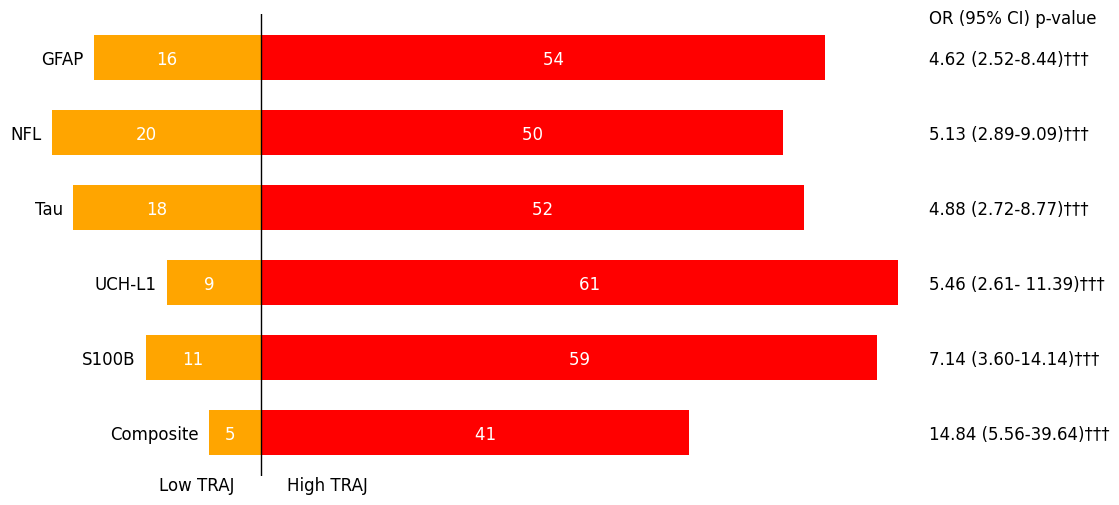

      time  biomarker QoLIB          Odds ratio Odds p value   Chi2 p value
0   3month  Composite  < 52  4.98 (1.92/ 12.89)        0.001  10.21   0.001
1   3month  Composite  > 52  4.98 (1.92/ 12.89)        0.001  10.21   0.001
2   6month  Composite  < 52   2.22 (0.88/ 5.64)        0.141   2.12   0.146
3   6month  Composite  > 52   2.22 (0.88/ 5.64)        0.141   2.12   0.146
4  12month  Composite  < 52   2.29 (0.88/ 5.99)        0.126   2.13   0.145
5  12month  Composite  > 52   2.29 (0.88/ 5.99)        0.126   2.13   0.145


C:\Users\thanh\AppData\Local\Temp\ipykernel_8292\2357339643.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[outcol] = df[outcol].apply(lambda x: 1 if x < 52 else 0)
C:\Users\thanh\AppData\Local\Temp\ipykernel_8292\2357339643.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[outcol] = df[outcol].apply(lambda x: 1 if x > 51 else 0)
C:\Users\thanh\AppData\Local\Temp\ipykernel_8292\2357339643.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

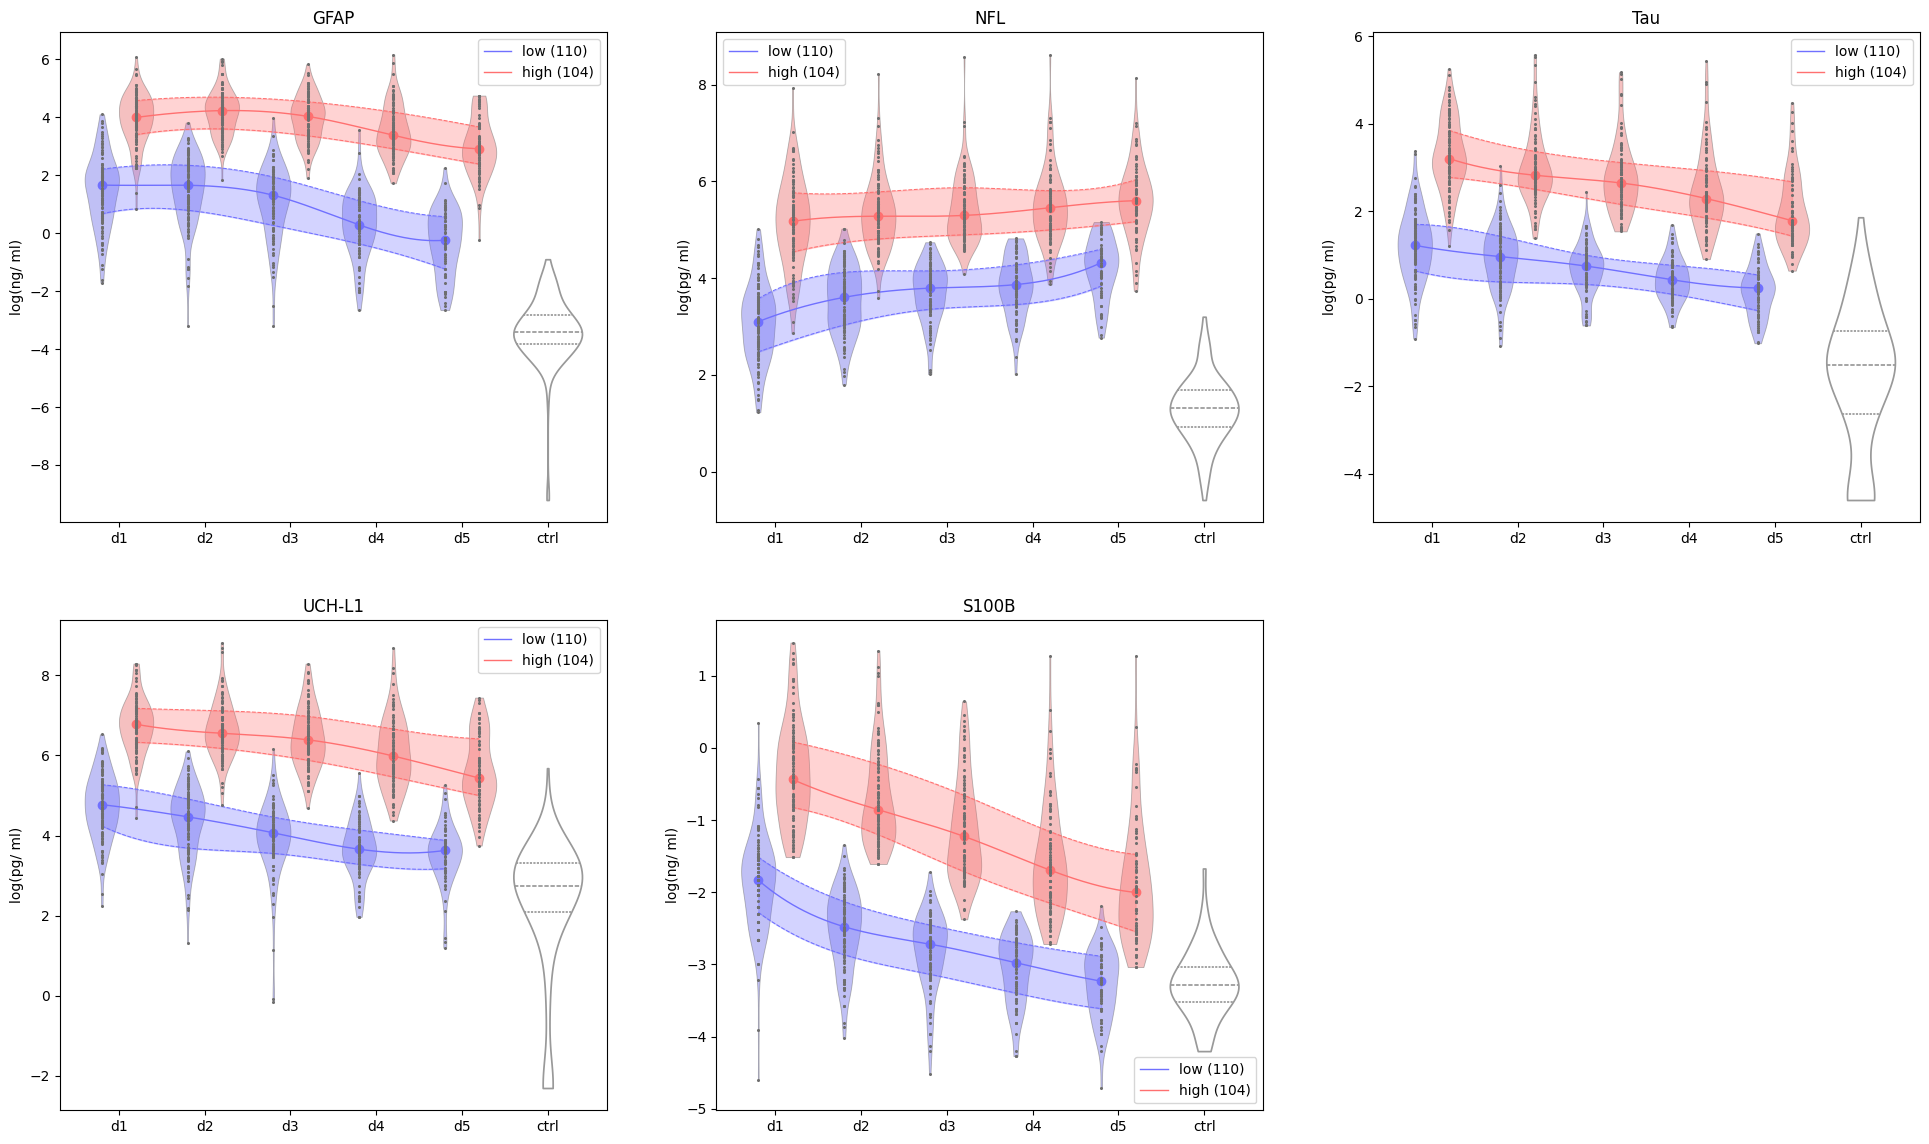

In [23]:
res = result(resultfolder=resultFolder373, dataFile=dataFile373, rankFile=rank373)
# res = result(resultfolder=resultFolder373d1, dataFile=dataFile373, rankFile=rank373d1)
# print(res.df['GFAP'])
# res = result(resultfolder=resultFolder462, dataFile=dataFile462, rankFile=rank462)
dfx = pd.DataFrame(columns=['odds ratio', 'chi2', 'p_value', 'odds pvalue'])
ro = []
r = []
for bio in biomarkers:

    ctitle, outcome = res.getoutcome(biomarker=bio)
    
    # print(bio)
    # row = QoLIB_chi2(outcome, classcol='Cluster')
    # dfx = pd.concat([dfx, row], axis = 0)
    print(bio)
    print(f"NA 3 month {outcome['QoLIB3month'].isna().sum()} 6 month: {outcome['QoLIB6month'].isna().sum()} 12 month: {outcome['QoLIB12month'].isna().sum()}")
    print(f"Not NA 3 month {outcome['QoLIB3month'].notna().sum()} 6 month: {outcome['QoLIB6month'].notna().sum()} 12 month: {outcome['QoLIB12month'].notna().sum()}")



    # compositechart4A(df=outcome, label='Cluster', title=bio, keys=[1,2])  #, figFile='../../paper_draft/composite/'  , figFile='../../paper_draft/composite2/'
    # qolibri_compositechart4(df=outcome, label='Cluster', title=bio, g_score = 51, p_score= 52, keys=[1,2]) #, figFile='../../paper_draft/composite2/'
    # death_compositechart4(df=outcome, label='Cluster', title=bio, keys=[1,2])  # , figFile='../../paper_draft/composite2/'
    # barchart2(df= outcome, biomarker=bio) #, figFile='../../paper_draft/composit/'
    # print(outcome.columns)
    # print(outcome.head())
    # print(f'GOSE missing: {outcome["GOSE6month"].isnull().sum()} ')
    # print(f'GOSE <= 4     : {(outcome["GOSE6month"] <= 4).sum()}')
    # print(f'GOSE in 5..8  : {(outcome["GOSE6month"] > 4).sum()}')
    # print(f'GOSE > 6      : {(outcome["GOSE6month"] > 6).sum()}')
    # print(f'GOSE <= 6     : {(outcome["GOSE6month"] <= 6).sum()}')
    # print(f'GOSE stats: {outcome["GOSE6month"].value_counts()}')
    
    # df=res.df[bio]
    # if bio == 'UCH-L1':
    #     print((df[df[bio + '_2'] > 4000][bio + '_2']))
    # print(outcome.columns)
    # print(outcome.iloc[0:2, :])
    # plotMean(df=res.df[bio], label=outcome['Cluster'], biomarker=bio, title=ctitle, isMedian=True)
    
    # Violin plotting
    # plotviolin(df=res.df[bio], label=outcome['Cluster'], biomarker=bio, title=bio) # , figFile='../../paper_draft/violin_plot/'+ctitle+'.png'
    df1 = res.df[bio].replace(0, np.nan)
    mask = ~np.isnan(df1)
    dflog = np.log(df1[mask])
    # plotbox(df=dflog, biomarker=bio, title=bio) #, figFile='../../paper_draft/box_plot/'+bio
    # plotviolin(df=dflog, label=outcome['Cluster'], biomarker=bio, title=bio) #, figFile='../../paper_draft/violin_plot/'+ctitle+'all_log.png'   , figFile='../../paper_draft/violin_plot/'+ctitle+'ctrl_log.png'
    # plt.figure(figsize=(4,3))
    # plotMean(df=dflog, label=outcome['Cluster'], biomarker=bio, title=ctitle, isMedian=True, x_shift=0) # figFile='../../paper_draft/median_plot/'+ctitle+'_median.png'
    # plt.show()
    # plotMean(df=res.df[bio], label=outcome['Cluster'], biomarker=bio, title=ctitle, isMedian=True, x_shift=0 ) # figFile='../../paper_draft/median_plot/'+ctitle+'_median.png'
    # plt.show()
    # plotMean(df=dflog, label=outcome['Cluster'], biomarker=bio, title=ctitle + ' log', isMedian=True)
    # plotMean(df=res.df[bio], label=outcome['Cluster'], biomarker=bio, title=ctitle, isMedian=False)
    # plotMean(df=dflog, label=outcome['Cluster'], biomarker=bio, title=ctitle + ' log', isMedian=False)

    # label = outcome['Cluster']
    # for c in [1,2]:
    #     # ro1 = outcome[label == c]['GOSE6month'].value_counts().to_dict()

    #     ro1 = {}
    #     ro1['Biomarker'] = bio
    #     ro1['Cluster'] = c
    #     ro1['Number of Subject'] = len(outcome[outcome['Cluster'] == c]['Cluster'])
    #     l = outcome[label == c]['QoLIB3month']
    #     ro1['missing at m3'] = f'{l.isna().sum()} {(100*l.isna().sum()/len(l)):.2f}%'
    #     ro1['Mean at m3'] = f'{l.mean():.2f}'
    #     ro1['Std Dev at m3'] = f'{l.std():.2f}'
    #     l = outcome[label == c]['QoLIB6month']
    #     ro1['missing at m6'] = f'{l.isna().sum()} {(100*l.isna().sum()/len(l)):.2f}%'
    #     ro1['Mean at m6'] = f'{l.mean():.2f}'
    #     ro1['Std Dev at m6'] = f'{l.std():.2f}'
    #     l = outcome[label == c]['QoLIB12month']
    #     ro1['missing at m12'] = f'{l.isna().sum()} {(100*l.isna().sum()/len(l)):.2f}%'
    #     ro1['Mean at m12'] = f'{l.mean():.2f}'
    #     ro1['Std Dev at m12'] = f'{l.std():.2f}'
    #     ro.append(ro1)
        # plt.figure(figsize=(10,3))
        # plt.subplot(1,3,1)
        # outcome[label == c]['GOSE3month'].hist(bins = 6)
        # plt.subplot(1,3,2)
        # outcome[label == c]['GOSE6month'].hist(bins = 6)
        # plt.subplot(1,3,3)
        # outcome[label == c]['GOSE12month'].hist(bins = 6)
        # plt.show()
#     lscol = ['d1', 'd2', 'd3', 'd4', 'd5']
#     df1 = res.df[bio].replace(0, np.nan)
#     for c in [1,2]:
#         for i, col in enumerate(df1.columns):
#             if i >4:
#                 continue
#             l = df1[label == c][col]
#             ro.append({
#                 'biomarker': bio,
#                 'cluster' : c,
#                 'data at'  : f'd{i+1}',
#                 'size': len(l),
#                 'Min' : f'{l.min():.2f}',
#                 'Max' : f'{l.max():.2f}',
#                 'Mean': f'{l.mean():.2f}',
#                 'Std dev' : f'{l.std():.2f}',
#                 'Median' : f'{l.median():.2f}',
#                 '1st Quartile': f'{l.quantile(0.25):.2f}',
#                 '3rd Quartile': f'{l.quantile(0.75):.2f}',
#             })
        
# rodf = pd.DataFrame(ro)
# rodf.to_csv('./ICU_biomarker_stat.csv', header= True, index=False)
# print(rodf)

# df1 = death_oddsbio(res, days=5)
# df1.to_csv('../../paper_draft/tables/death_by_day5.csv', header=True, index=False)
# print(f'biomarker death 5\n{df1}')
df1 = death_oddsbio(res, days=180)
# print(df1)
# df1.to_csv('../../paper_draft/tables/death_by_day150.csv', header=True, index=False)
df1 = qolib_oddsbio(res)
# df1.to_csv('../../paper_draft/tables/qolib_oddsratio_final.csv', header=True, index=False)
print(df1)
# print(f'biomarker death 150\n{df1}')
# composit(data=res, biomarkerset=['GFAP', 'Tau', 'UCH-L1'])     #figFile='../../paper_draft/composit/'
# composit(data=res, biomarkerset=['GFAP', 'Tau', 'NFL', 'S100B'])
# venn3diagram(data=res,isneuroworse=False, isGOSE=False) # figFile='../../paper_draft/venn3/'
# venn4diagram(data=res, figFile='../../paper_draft/venn45/')
# venn5diagram(data=res, figFile='../../paper_draft/venn45/') #, figFile='../../paper_draft/venn45/'
# dfx = ttest(res)
# dfx
# dfx.to_csv('../../paper_draft/tables/U_test.csv', header=True, index=True)
# dfx.to_csv(res.statsPath + '/T_U_stats.csv', header=True, index=True)


# print(df1)
# df1 = linearMM(res) # figpath = '../../paper_draft/GOSE_bar/'
# df2 = oddsRatio(res)
# df3 = pd.merge_ordered(df1, df2, how='outer', on=['biomarker', 'outcome', 'month'])
# print(df1)
# print(df2)
# df4 = df3[['biomarker', 'outcome', 'month', 'Chi2', 'LMM Std Err', 'Odds ratio', 'Chi2 p value', 'LMM p value', 'Odds p value']]
# print(df4)
# df4.to_csv('../../paper_draft/tables/LMM_Odds_Chi2.csv', header=True, index=True)
# dfx.index = biomarkers
# print(dfx)
# dfx.to_csv('../../paper_draft/tables/QoLIBRI_chi2_12month.csv', header = True, index=True)
bio5 = ['GFAP', 'NFL', 'Tau', 'UCH-L1', 'S100B']
# bio4 = ['GFAP', 'Tau', 'S100B', 'UCH-L1']
# g_score = 3
# p_score = 4
# for i1, b1 in enumerate(bio5):
#     for i2, b2 in enumerate(bio5):
#         if (i1 < i2):
#             composit(data=res, biomarkerset=[b1, b2], g_score=g_score, p_score = p_score)
# for i1, b1 in enumerate(bio5):
#     for i2, b2 in enumerate(bio5):
#         for i3, b3 in enumerate(bio5):
#             if (i1 < i2) and (i2 < i3):
#                 composit(data=res, biomarkerset=[b1, b2, b3], g_score=g_score, p_score=p_score)
# for i1, b1 in enumerate(bio5):
#     for i2, b2 in enumerate(bio5):
#         for i3, b3 in enumerate(bio5):
#             for i4, b4 in enumerate(bio5):
#                 if (i1 < i2) and (i2 < i3) and (i3 < i4):
#                     composit(data=res, biomarkerset=[b1, b2, b3, b4], g_score=g_score, p_score=p_score)
composite(data=res, biomarkerset=bio5, g_score = 6, p_score = 5) #figFile='../../paper_draft/composite/'  , figFile='../../paper_draft/composite2/'
# neuroworsen_barchart2(data=res )  #figFile='../../paper_draft/composite/'
# gcs_barchart2(data=res) #, figFile='../../paper_draft/composite/'

In [22]:
df2
# df2.to_csv('../../paper_draft/day1 vs 5 days/day 1 GOSE_stat.csv', header=True, index=False)

,GFAP,NFL,Tau,UCH-L1
serum label BRH,,,,
966450,NaN,NaN,NaN,NaN
1067625,0.047015,2.771224,0.268040,18.309728
1067626,0.048722,2.675160,0.010000,2.136064
1067628,0.017307,3.027688,0.010000,15.059824
1067630,0.069882,1.884848,0.583272,12.298608
...,...,...,...,...
HMN17088,0.025344,1.977368,0.165912,28.085592
HMN17089,0.006540,0.555384,0.987296,0.100000
HMN17090,0.030574,3.985600,0.316744,24.819832


In [23]:
dfx
# dfx.to_csv('../../paper_draft/day1 vs 5 days/biomarker_utest_5days.csv', header=True, index=False)

,odds ratio,chi2,p_value,odds pvalue


In [24]:
# df2.to_csv('../../paper_draft/day1 vs 5 days/biomarker_chi2_odd_ci_day1.csv', header=True, index=False)
df2

,GFAP,NFL,Tau,UCH-L1
serum label BRH,,,,
966450,NaN,NaN,NaN,NaN
1067625,0.047015,2.771224,0.268040,18.309728
1067626,0.048722,2.675160,0.010000,2.136064
1067628,0.017307,3.027688,0.010000,15.059824
1067630,0.069882,1.884848,0.583272,12.298608
...,...,...,...,...
HMN17088,0.025344,1.977368,0.165912,28.085592
HMN17089,0.006540,0.555384,0.987296,0.100000
HMN17090,0.030574,3.985600,0.316744,24.819832


END

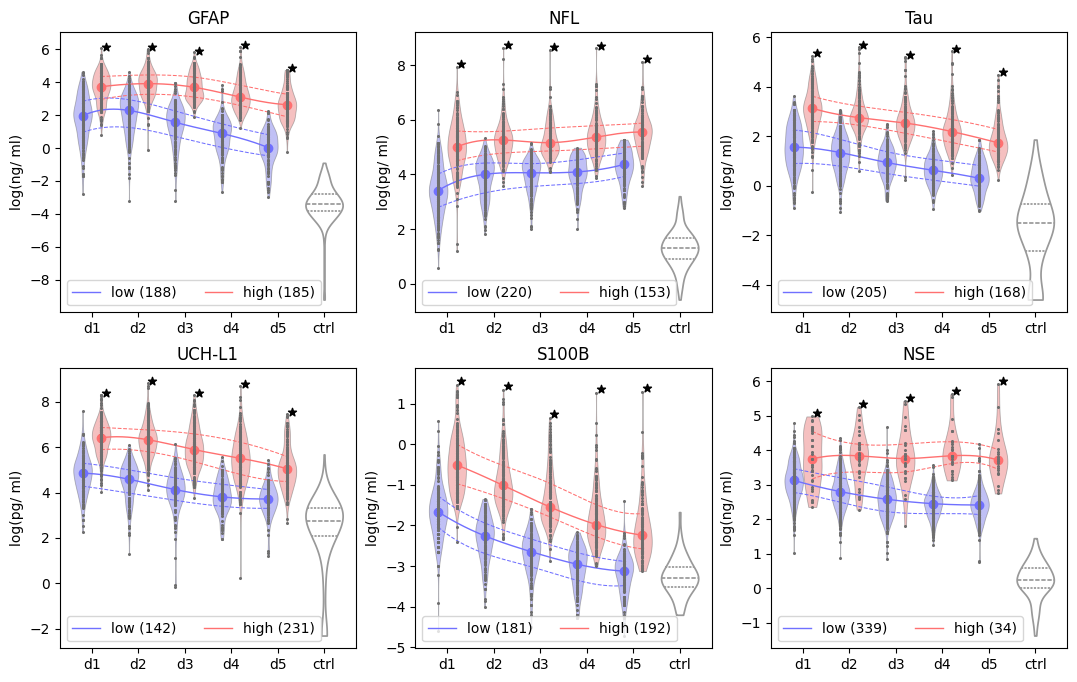

In [25]:
plt.figure(figsize=(13,8))
plt.rcParams.update({'font.size': 10})
for i, bio in enumerate(biomarkers): 
    ctitle, outcome = res.getoutcome(biomarker=bio)
    df1 = res.df[bio].replace(0, np.nan)
    mask = ~np.isnan(df1)
    dflog = np.log(df1[mask])
    # plotbox(df=dflog, biomarker=bio, title=bio) #, figFile='../../paper_draft/box_plot/'+bio
    plt.subplot(2, 3, i+1)
    # plt.rcParams.update({'font.size': 12})
    # plotbox(df=dflog, biomarker=bio, title=bio) #, figFile='../../paper_draft/box_plot/'+bio
    plotviolin(df=dflog, label=outcome['Cluster'], biomarker=bio, title=bio) #, figFile='../../paper_draft/violin_plot/'+ctitle+'all_log.png'   , figFile='../../paper_draft/violin_plot/'+ctitle+'ctrl_log.png'
# plt.suptitle('Figure 2a. Trajectory group distributions in logscale of biomarkers', fontsize='30', y=-0.001)
plt.show()